# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 20

In [2]:
cluster = '20'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 608
Num noneffect sequences: 608


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref  \
407  chr19   45001090   45001091   rs35577563      C         G   C   
33   chr11   60251676   60251677     rs636317      T         C   C   
421  chr19   45326535   45326536     rs344791      C         G   G   
169  chr17   45848599   45848600   rs62054817      G         A   G   
456   chr2  127128581  127128582   rs13025717      T         C   C   
79   chr15   58758182   58758183    rs2250583      C         T   C   
570   chr6   27772520   27772521     rs760587      C         A   C   
299  chr17   46130945   46130946    rs6503457      T         G   G   
203  chr17   45895214   45895215   rs74457229      T         C   C   
178  chr17   45852871   45852872   rs79589869      C         A   C   
539   chr4   89829436   89829437    rs2583979      T         A   A   
362  chr19   44644418   44644419   rs10426401      T         G   T   
559   chr4   89837895   89837896    rs2619363      T         G   G   
25   chr11   47373688   47373689    rs7940536      A         G   G   
356  chr19   18462023   18462024    rs8103622      T         C   C   
194  chr17   45882974   45882975   rs56127309      G         A   G   
70   chr14   67517150   67517151    rs7161368      T         C   C   
481   chr3   49007333   49007334    rs6781790      T         C   C   
162  chr17   45827030   45827031   rs17689824      T         C   C   
61   chr12   40224294   40224295    rs1388597      G         A   A   
210  chr17   45896285   45896286   rs62056780      T         C   C   
171  chr17   45848782   45848783   rs62054819      G         A   A   
34   chr11   60251687   60251688     rs636341      A         C   A   
273  chr17   46082482   46082483   rs17576165      T         C   T   
218  chr17   45914204   45914205  rs141801658      I         D   G   
117  chr17    4901871    4901872   rs79436576      T         C   C   
55   chr11   86148440   86148441   rs10898439      G         C   G   
563   chr5  102971887  102971888    rs6881225      T         C   T   
334  chr17   78426790   78426791   rs72914885      C         A   A   
246  chr17   45947195   45947196   rs62062785      T         G   G   
..     ...        ...        ...          ...    ...       ...  ..   
420  chr19   45326123   45326124     rs344792      A         G   G   
36   chr11   65834088   65834089   rs17854357      C         G   G   
560   chr5   60768557   60768558    rs9291696      T         C   C   
45   chr11   86016986   86016987    rs1996108      T         C   T   
453   chr2  127118665  127118666   rs71414738      T         C   C   
257  chr17   46002672   46002673   rs62064663      T         G   T   
364  chr19   44808489   44808490    rs8113171      C         G   G   
300  chr17   46142464   46142465    rs1819040      T         A   T   
260  chr17   46013279   46013280   rs12150170      A         G   A   
328  chr17   75035407   75035408   rs80319906      A         G   G   
124  chr17    4909107    4909108   rs16954243      A         T   A   
109  chr17    4858664    4858665  rs111985639      T         C   T   
502   chr4     959405     959406   rs34931738      I         D  TC   
175  chr17   45849620   45849621    rs8068916      T         G   T   
42   chr11   85955396   85955397     rs556562      A         C   A   
176  chr17   45849625   45849626   rs56269136      T         C   C   
450   chr2  127107527  127107528  2_127107528    NAN       NAN   .   
75   chr14   74713030   74713031    rs2270425      G         C   C   
479   chr3   48948965   48948966   rs13315711      T         A   A   
423   chr2   95071933   95071934    rs4854244      C         A   A   
412  chr19   45045876   45045877  rs112481437      A         G   G   
291  chr17   46122711   46122712  rs112560196      T         A   A   
278  chr17   46101517   46101518   rs62061810      G         A   G   
126  chr17    5111493    5111494   rs56229705      A         G   G   
250  chr17   45949128   45949129   rs74531363      G         A   A   
357  chr19   1847

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs35577563   ||    chr19 : 45001090 - 45001091   ||    Locus: 407   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  3.70E-12
Alzheimers_Kunkle_2019 		  4.76E-09
Alzheimers_Lambert_2013 	  2.68E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.412   ||   Center / 200bp : 0.6578
Noneffect Sequence : AGAGCCCTGGCAACCTCTCG


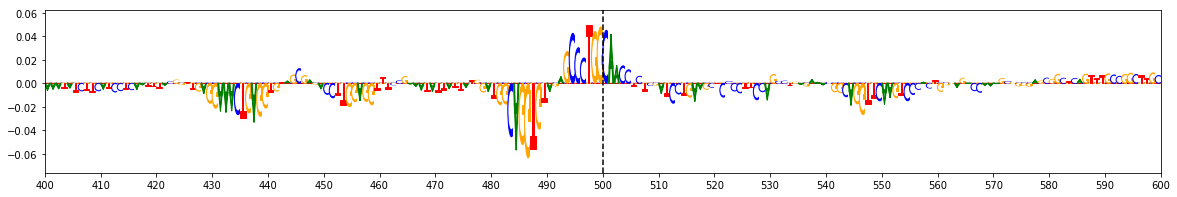

Effect Allele : C   ||   Explain Score : 0.1001   ||   Center / 200bp : 0.3189
Effect Sequence : AGAGCCCTGCCAACCTCTCG


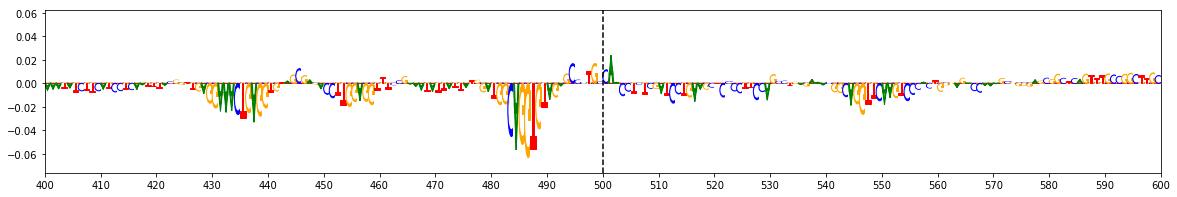

Allele Ratio : 0.2428   ||   Allele Difference : -0.3658  ||  ISM Score : -0.5707  ||  deltaSVM Score : -3.3006


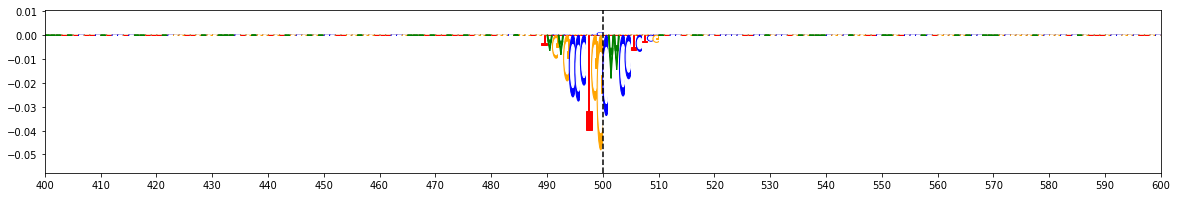


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs636317   ||    chr11 : 60251676 - 60251677   ||    Locus: 33   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  2.83E-13
Alzheimers_Kunkle_2019 		  5.91E-15
Alzheimers_Lambert_2013 	  1.41E-10

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 3.4451   ||   Center / 200bp : 0.7698
Noneffect Sequence : CTTTGCTGCCATCTGCTGGG


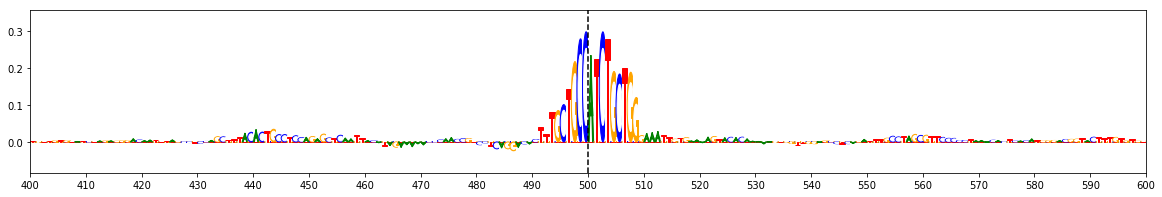

Effect Allele : T   ||   Explain Score : 1.1455   ||   Center / 200bp : 0.5264
Effect Sequence : CTTTGCTGCTATCTGCTGGG


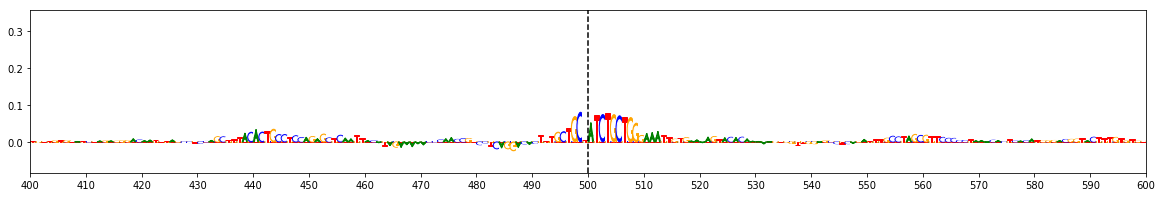

Allele Ratio : 0.3325   ||   Allele Difference : -2.3054  ||  ISM Score : -3.5858  ||  deltaSVM Score : -20.6859


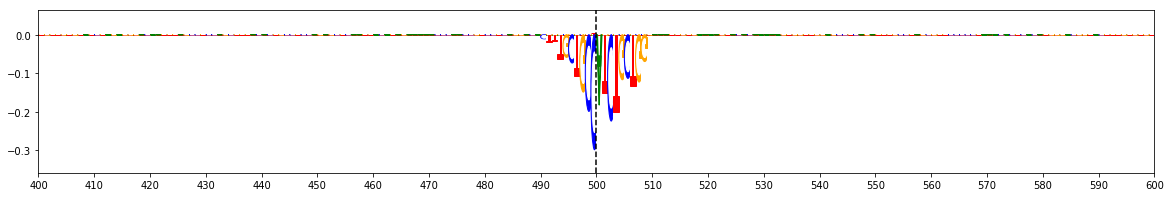


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 421   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.22E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.524   ||   Center / 200bp : 0.5677
Noneffect Sequence : CTCAAGACCGCCTCCACTGT


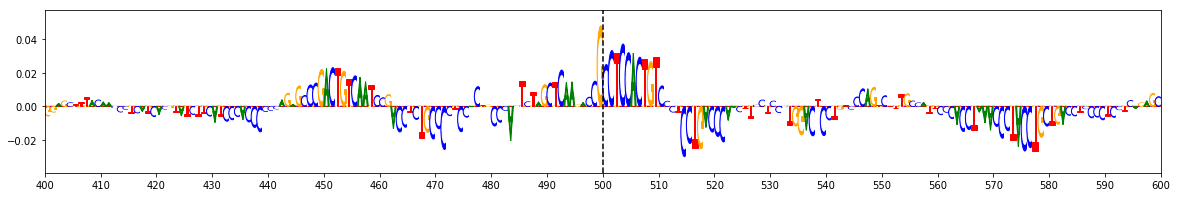

Effect Allele : C   ||   Explain Score : 0.1893   ||   Center / 200bp : 0.3242
Effect Sequence : CTCAAGACCCCCTCCACTGT


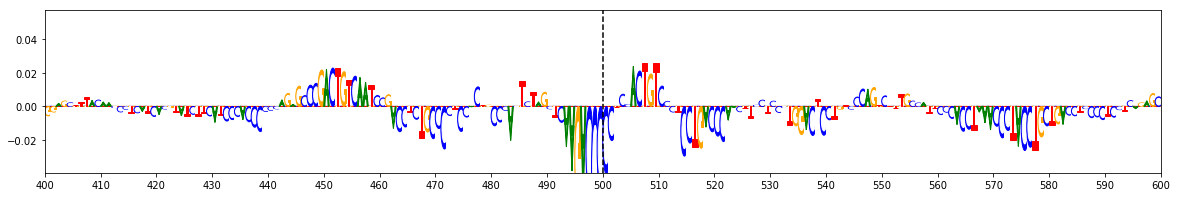

Allele Ratio : 0.3613   ||   Allele Difference : -0.7658  ||  ISM Score : -1.2188  ||  deltaSVM Score : -7.0549


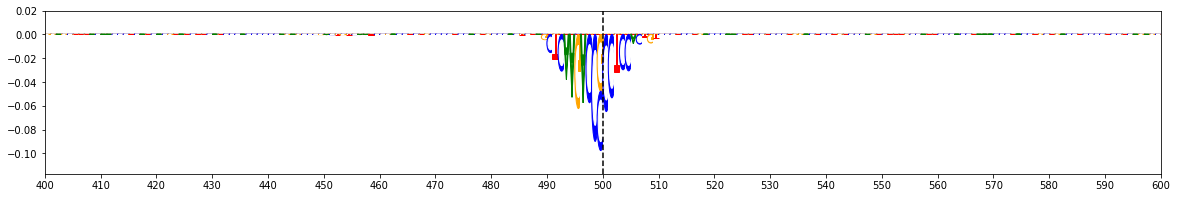


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62054817   ||    chr17 : 45848599 - 45848600   ||    Locus: 169   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.14E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 1.6359   ||   Center / 200bp : 0.7687
Noneffect Sequence : ATCTTCCCCAGTAGAGGGCC


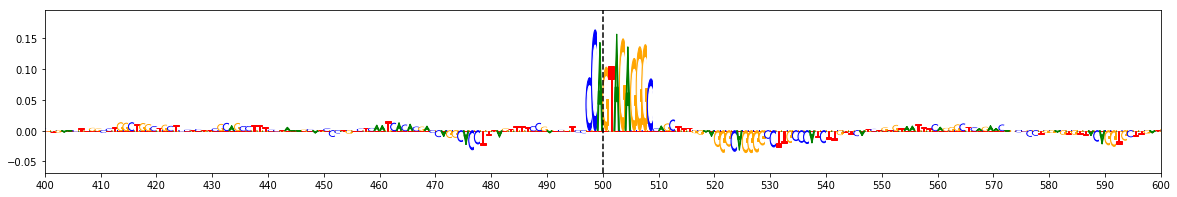

Effect Allele : G   ||   Explain Score : 0.8552   ||   Center / 200bp : 0.6347
Effect Sequence : ATCTTCCCCGGTAGAGGGCC


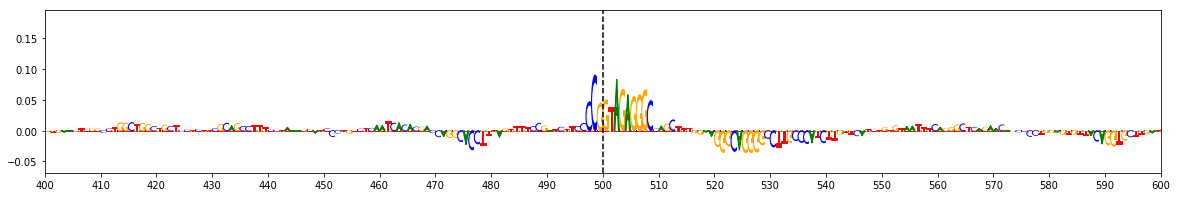

Allele Ratio : 0.5228   ||   Allele Difference : -0.7724  ||  ISM Score : -1.2172  ||  deltaSVM Score : -7.0046


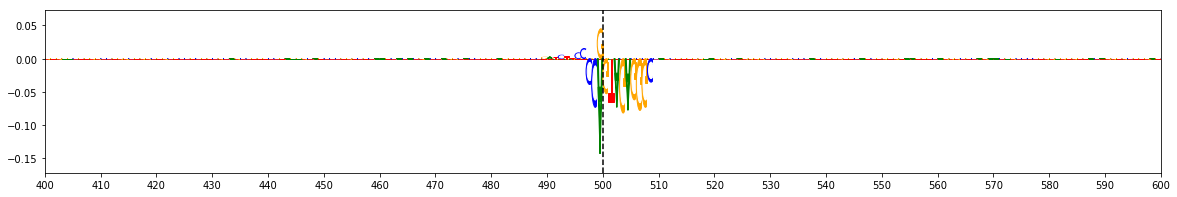


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs13025717   ||    chr2 : 127128581 - 127128582   ||    Locus: 456   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  9.13E-17
Alzheimers_Kunkle_2019 		  2.98E-15
Alzheimers_Lambert_2013 	  7.94E-13

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.0243   ||   Center / 200bp : 0.5205
Noneffect Sequence : CAGAAGCCCCGCCCAATGAG


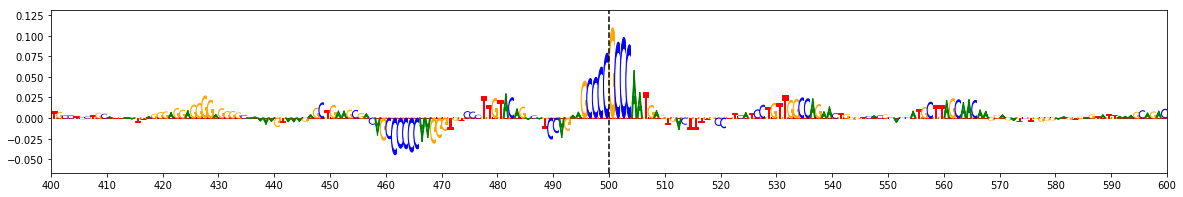

Effect Allele : T   ||   Explain Score : 0.4017   ||   Center / 200bp : 0.2987
Effect Sequence : CAGAAGCCCTGCCCAATGAG


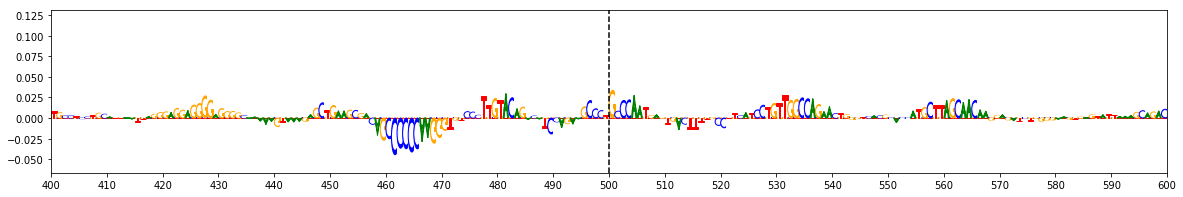

Allele Ratio : 0.3922   ||   Allele Difference : -0.5916  ||  ISM Score : -0.9225  ||  deltaSVM Score : -5.1945


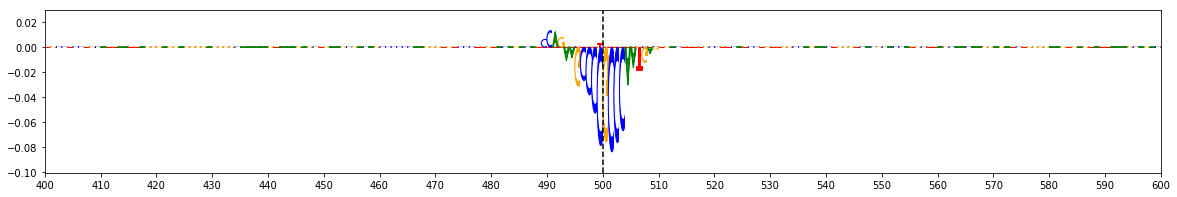


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2250583   ||    chr15 : 58758182 - 58758183   ||    Locus: 79   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  8.26E-09

Coloc:  False

Noneffect Allele : T   ||   Explain Score : 0.7786   ||   Center / 200bp : 0.8339
Noneffect Sequence : ATGAGCCATTGAGCCTGGCC


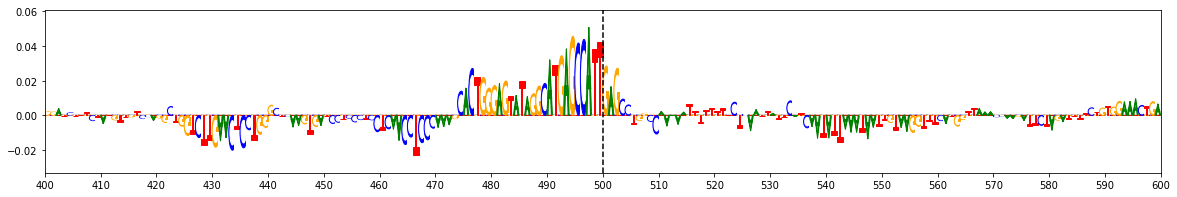

Effect Allele : C   ||   Explain Score : 0.5394   ||   Center / 200bp : 0.7766
Effect Sequence : ATGAGCCATCGAGCCTGGCC


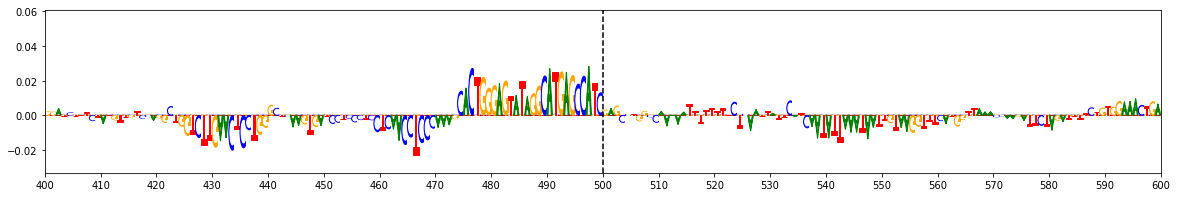

Allele Ratio : 0.6927   ||   Allele Difference : -0.2289  ||  ISM Score : -0.3691  ||  deltaSVM Score : -2.1874


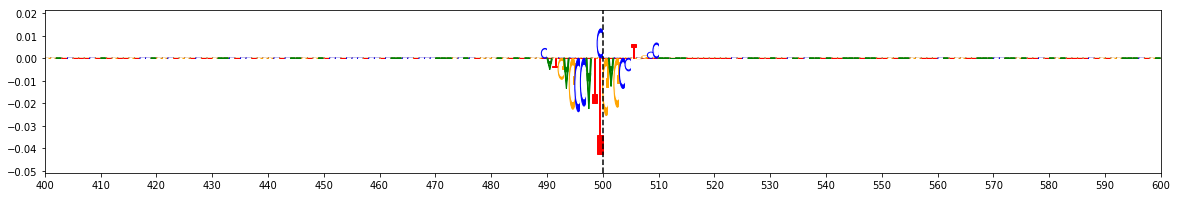


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs760587   ||    chr6 : 27772520 - 27772521   ||    Locus: 570   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  6.44E-06

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 1.4495   ||   Center / 200bp : 0.5861
Noneffect Sequence : GAGCAGCAAACAAAGGCTAA


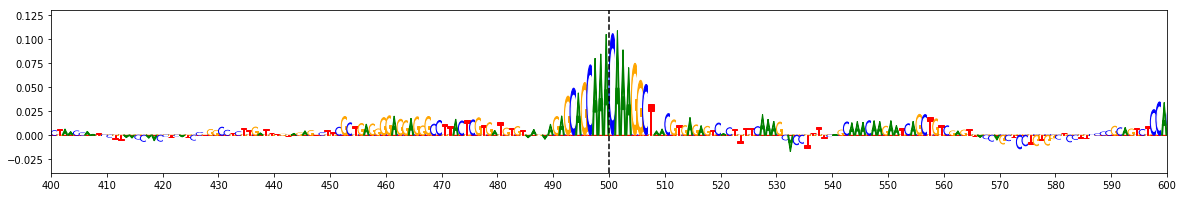

Effect Allele : C   ||   Explain Score : 0.7634   ||   Center / 200bp : 0.4263
Effect Sequence : GAGCAGCAACCAAAGGCTAA


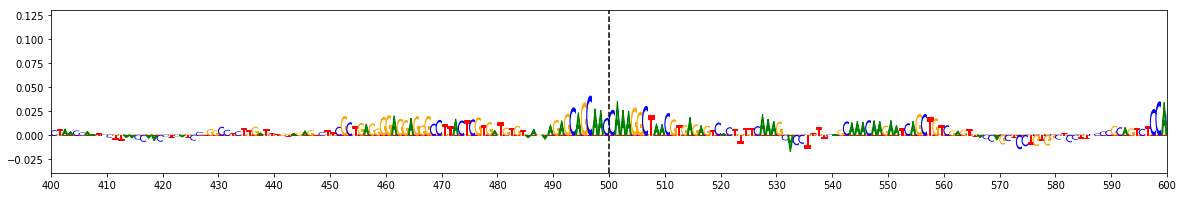

Allele Ratio : 0.5267   ||   Allele Difference : -0.6861  ||  ISM Score : -1.078  ||  deltaSVM Score : -6.1549


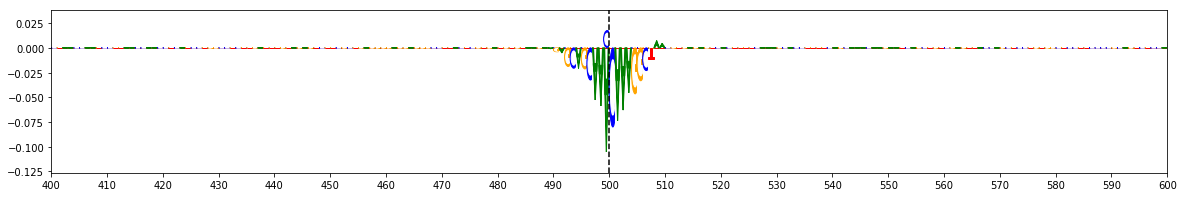


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6503457   ||    chr17 : 46130945 - 46130946   ||    Locus: 299   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  5.17E-21
Parkinsons_Pankratz_2012 	  2.80E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.5631   ||   Center / 200bp : 0.4102
Noneffect Sequence : GCACAAGAGGAAAGCAAAAC


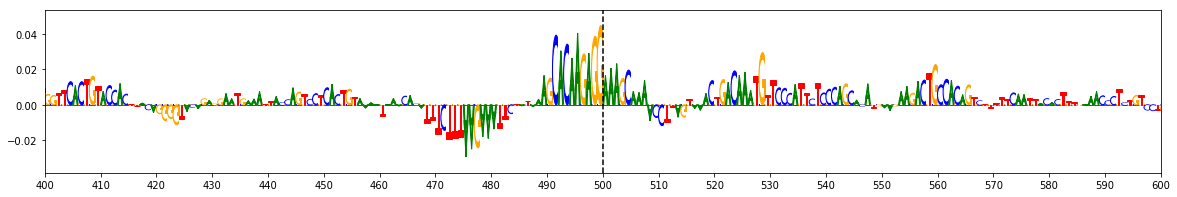

Effect Allele : T   ||   Explain Score : 0.2246   ||   Center / 200bp : 0.2171
Effect Sequence : GCACAAGAGTAAAGCAAAAC


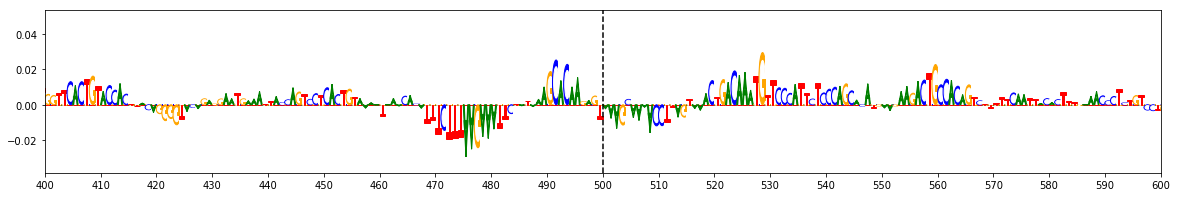

Allele Ratio : 0.3989   ||   Allele Difference : -0.41  ||  ISM Score : -0.6454  ||  deltaSVM Score : -3.7398


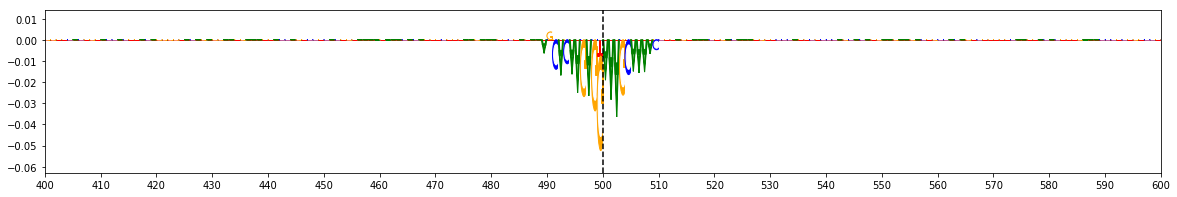


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs74457229   ||    chr17 : 45895214 - 45895215   ||    Locus: 203   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.7848   ||   Center / 200bp : 0.5889
Noneffect Sequence : ACGCCCCTCCCTGCACCTCC


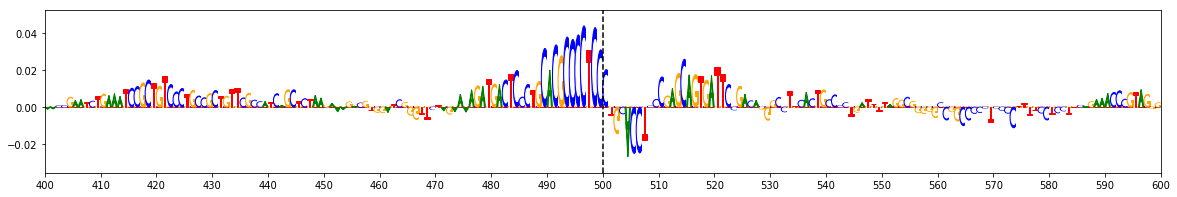

Effect Allele : T   ||   Explain Score : 0.4554   ||   Center / 200bp : 0.4519
Effect Sequence : ACGCCCCTCTCTGCACCTCC


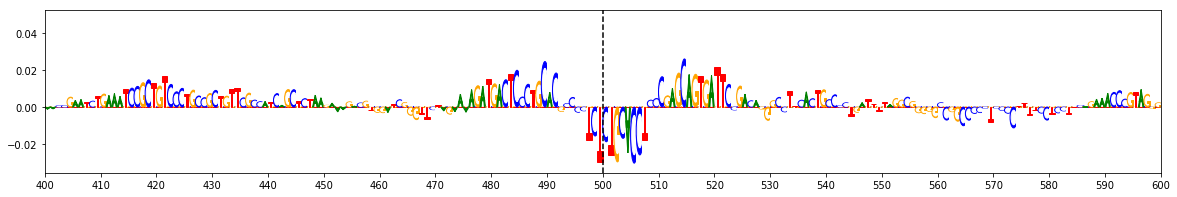

Allele Ratio : 0.5802   ||   Allele Difference : -0.4719  ||  ISM Score : -0.7857  ||  deltaSVM Score : -4.6938


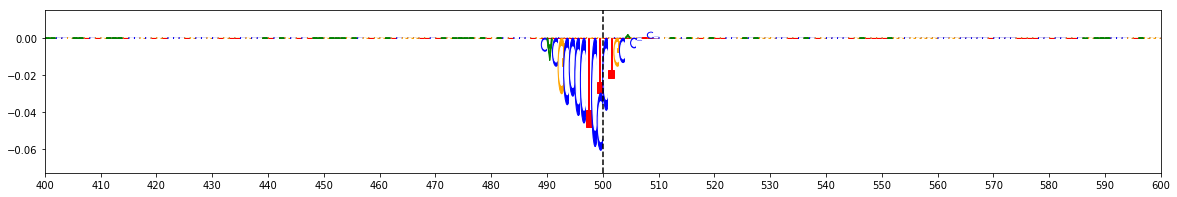


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79589869   ||    chr17 : 45852871 - 45852872   ||    Locus: 178   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.11E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 4.1695   ||   Center / 200bp : 0.9073
Noneffect Sequence : TTGAATGCTACTGTGCTGCC


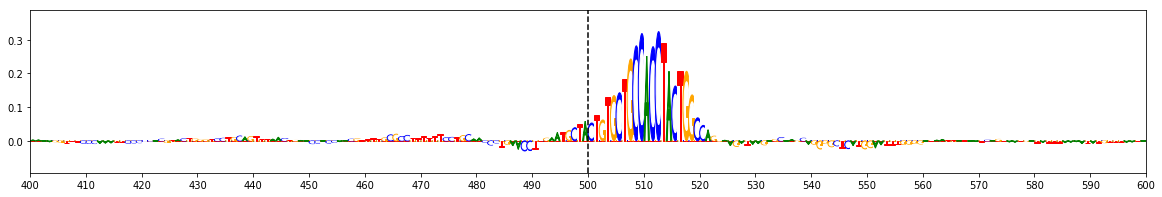

Effect Allele : C   ||   Explain Score : 3.7638   ||   Center / 200bp : 0.8983
Effect Sequence : TTGAATGCTCCTGTGCTGCC


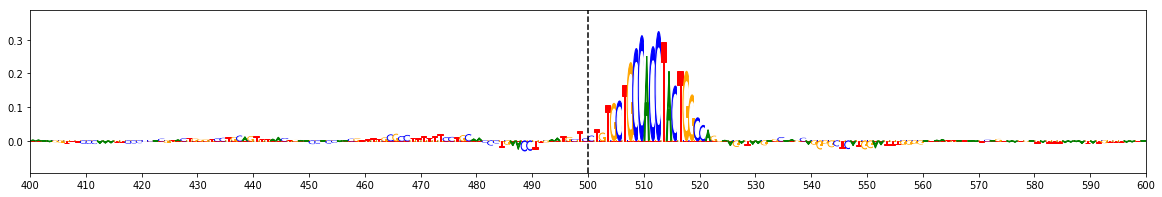

Allele Ratio : 0.9027   ||   Allele Difference : -0.4105  ||  ISM Score : -0.643  ||  deltaSVM Score : -3.697


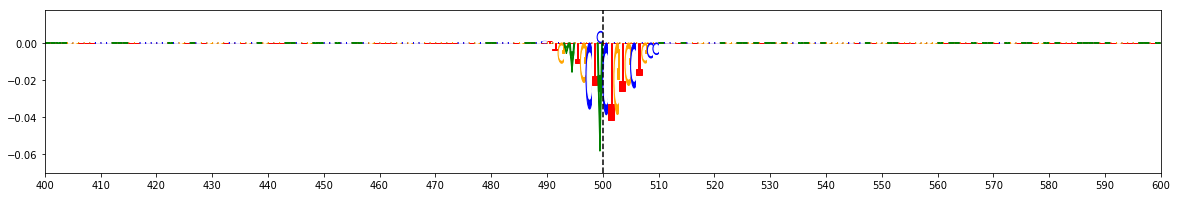


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2583979   ||    chr4 : 89829436 - 89829437   ||    Locus: 539   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  3.63E-14

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.4854   ||   Center / 200bp : 0.5364
Noneffect Sequence : TTTTCAGCAACACTTCCTCT


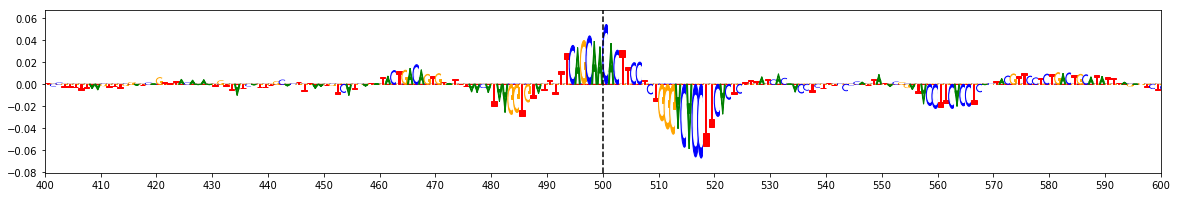

Effect Allele : T   ||   Explain Score : 0.2592   ||   Center / 200bp : 0.3823
Effect Sequence : TTTTCAGCATCACTTCCTCT


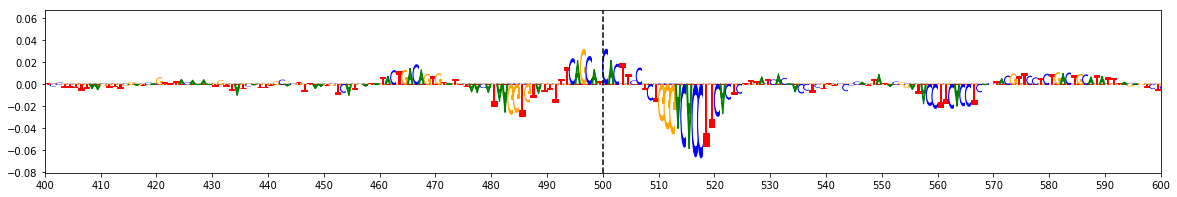

Allele Ratio : 0.534   ||   Allele Difference : -0.247  ||  ISM Score : -0.3904  ||  deltaSVM Score : -2.2614


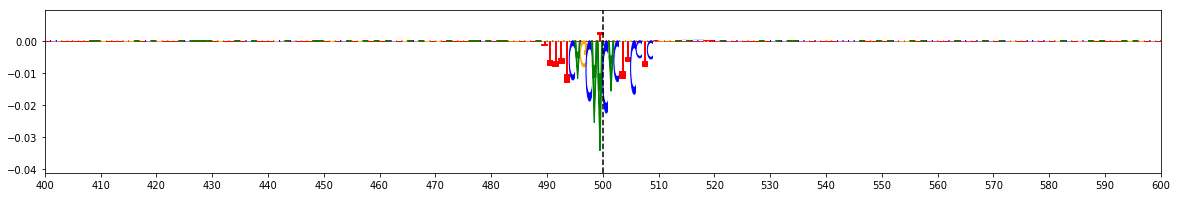


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10426401   ||    chr19 : 44644418 - 44644419   ||    Locus: 362   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.63E-14
Alzheimers_Kunkle_2019 		  5.66E-11
Alzheimers_Lambert_2013 	  2.79E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.8851   ||   Center / 200bp : 0.5583
Noneffect Sequence : CAACACGGGGCGGGCACAAG


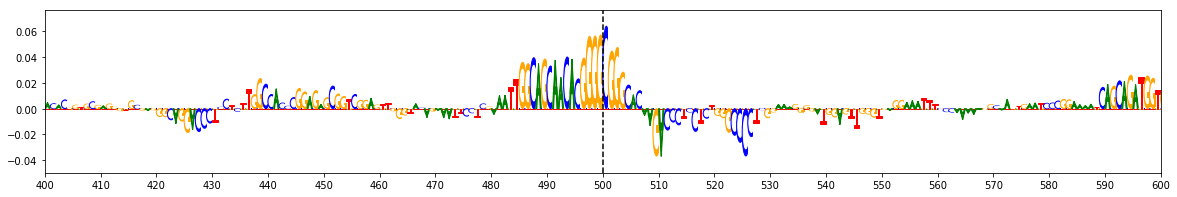

Effect Allele : T   ||   Explain Score : 0.4923   ||   Center / 200bp : 0.4123
Effect Sequence : CAACACGGGTCGGGCACAAG


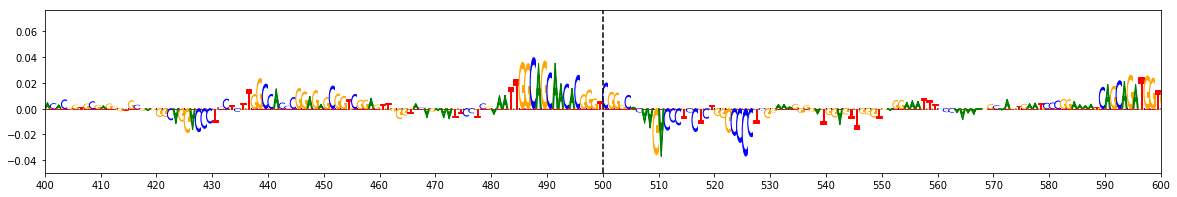

Allele Ratio : 0.5563   ||   Allele Difference : -0.4027  ||  ISM Score : -0.643  ||  deltaSVM Score : -3.6865


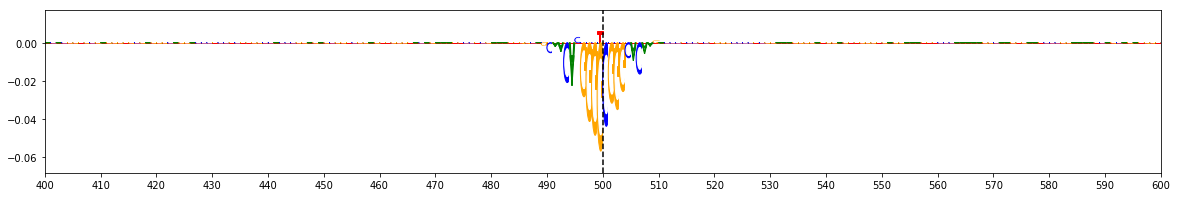


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 559   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.43E-08

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.0803   ||   Center / 200bp : 0.536
Noneffect Sequence : CCAATCAGCGCCTGCCAGAC


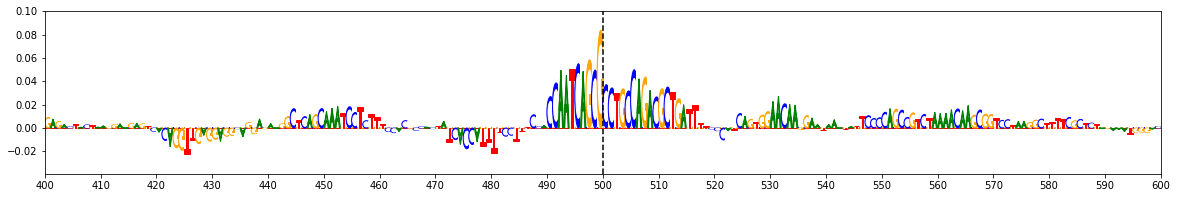

Effect Allele : T   ||   Explain Score : 0.5956   ||   Center / 200bp : 0.3873
Effect Sequence : CCAATCAGCTCCTGCCAGAC


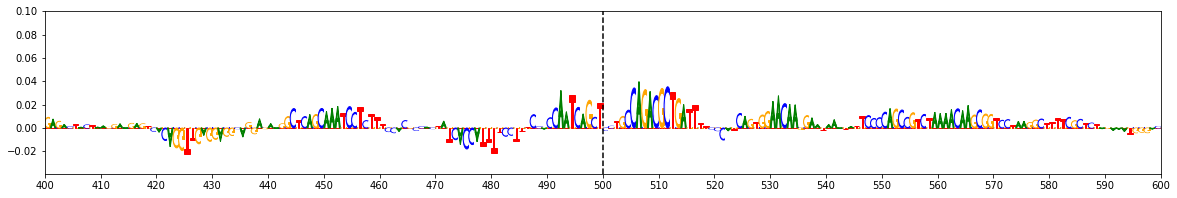

Allele Ratio : 0.5513   ||   Allele Difference : -0.4889  ||  ISM Score : -0.7399  ||  deltaSVM Score : -4.4929


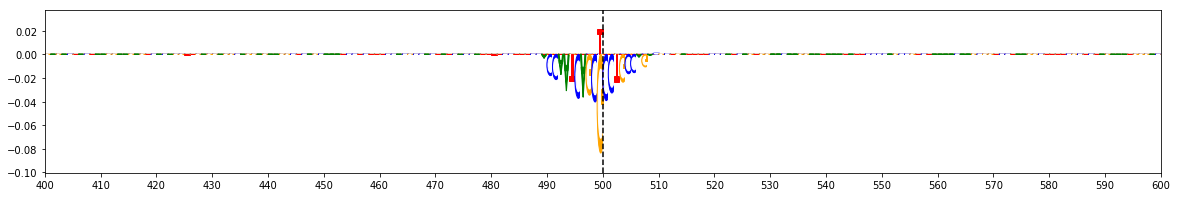


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7940536   ||    chr11 : 47373688 - 47373689   ||    Locus: 25   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  2.79E-10

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.1363   ||   Center / 200bp : 0.6707
Noneffect Sequence : GCCCTGATTGGCAGTGATTA


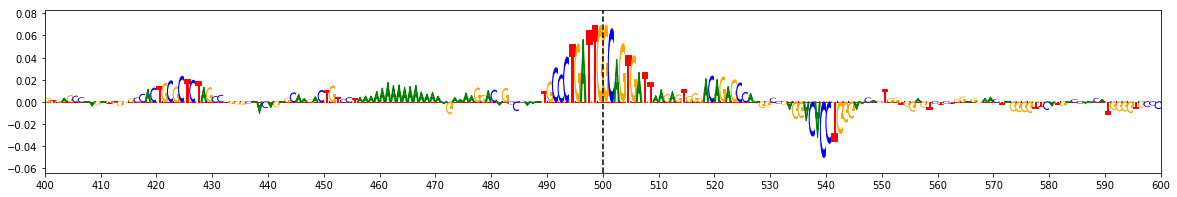

Effect Allele : A   ||   Explain Score : 0.7937   ||   Center / 200bp : 0.5873
Effect Sequence : GCCCTGATTAGCAGTGATTA


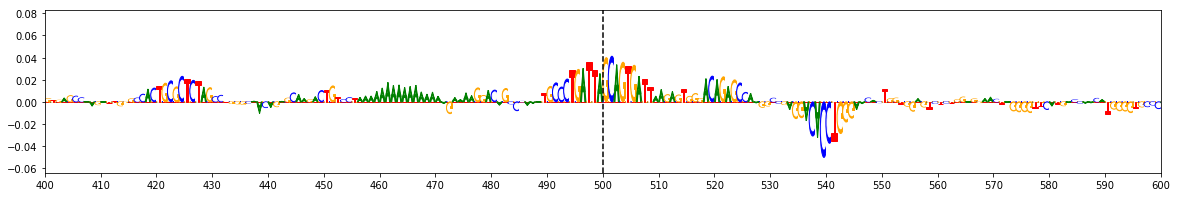

Allele Ratio : 0.6985   ||   Allele Difference : -0.3426  ||  ISM Score : -0.6093  ||  deltaSVM Score : -3.5139


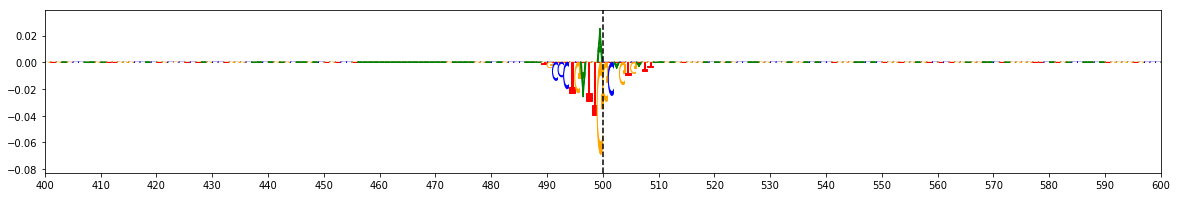


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs8103622   ||    chr19 : 18462023 - 18462024   ||    Locus: 356   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  7.31E-02
Alzheimers_Kunkle_2019 		  1.28E-05
Alzheimers_Lambert_2013 	  3.29E-05

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 2.3528   ||   Center / 200bp : 0.6772
Noneffect Sequence : GACCAAGAGCGCCACCTGCT


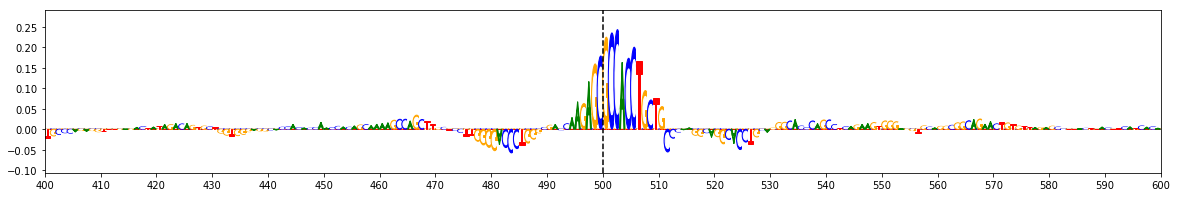

Effect Allele : T   ||   Explain Score : 1.7183   ||   Center / 200bp : 0.6052
Effect Sequence : GACCAAGAGTGCCACCTGCT


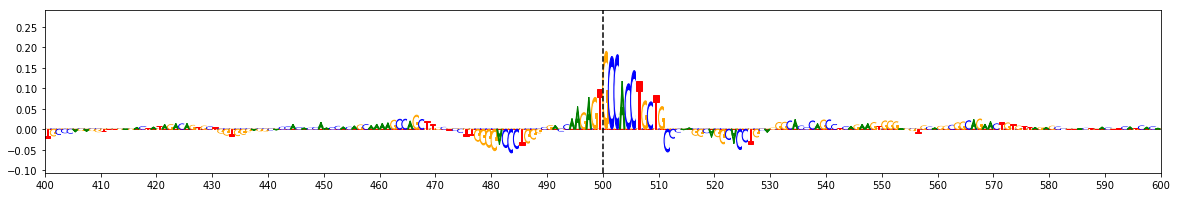

Allele Ratio : 0.7303   ||   Allele Difference : -0.6372  ||  ISM Score : -1.0476  ||  deltaSVM Score : -5.9743


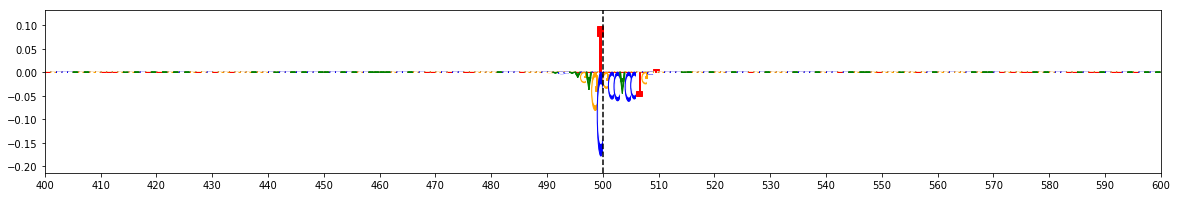


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs56127309   ||    chr17 : 45882974 - 45882975   ||    Locus: 194   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  4.43E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 1.1805   ||   Center / 200bp : 0.5553
Noneffect Sequence : AGACTGCACATGCAGCTTGC


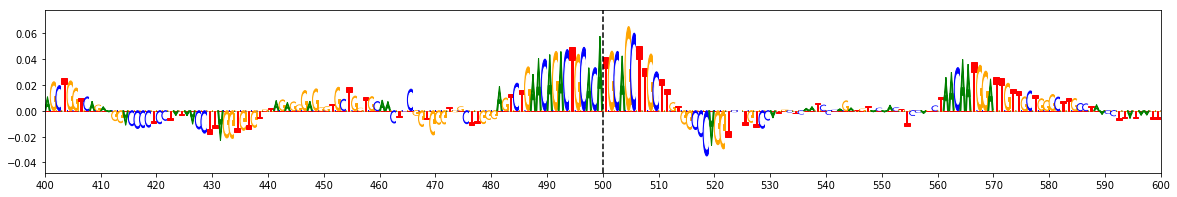

Effect Allele : G   ||   Explain Score : 0.7388   ||   Center / 200bp : 0.4429
Effect Sequence : AGACTGCACGTGCAGCTTGC


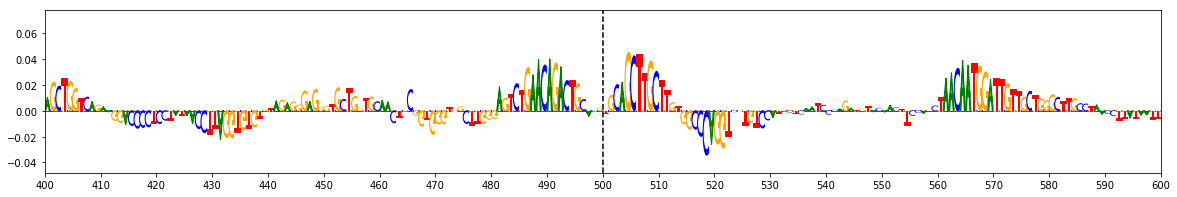

Allele Ratio : 0.6258   ||   Allele Difference : -0.4437  ||  ISM Score : -0.7099  ||  deltaSVM Score : -3.9129


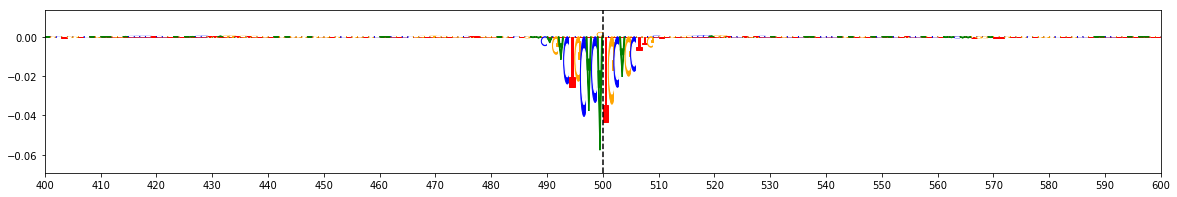


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7161368   ||    chr14 : 67517150 - 67517151   ||    Locus: 70   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  4.56E-01

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.3704   ||   Center / 200bp : 0.6762
Noneffect Sequence : AGGGACACGCTGGCAAGAAG


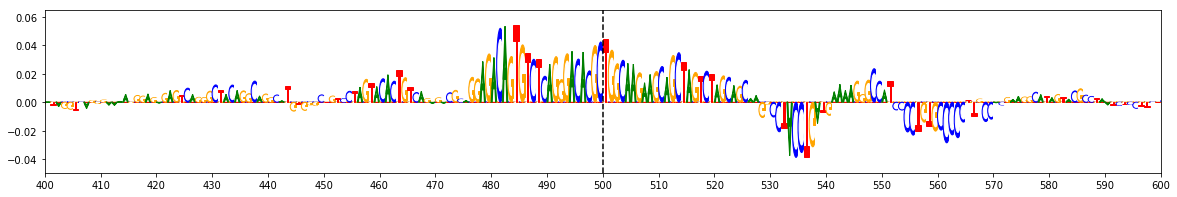

Effect Allele : T   ||   Explain Score : 1.0569   ||   Center / 200bp : 0.6168
Effect Sequence : AGGGACACGTTGGCAAGAAG


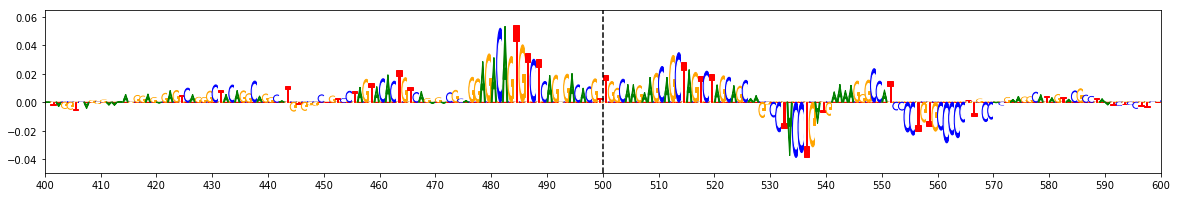

Allele Ratio : 0.7713   ||   Allele Difference : -0.3135  ||  ISM Score : -0.4862  ||  deltaSVM Score : -2.8538


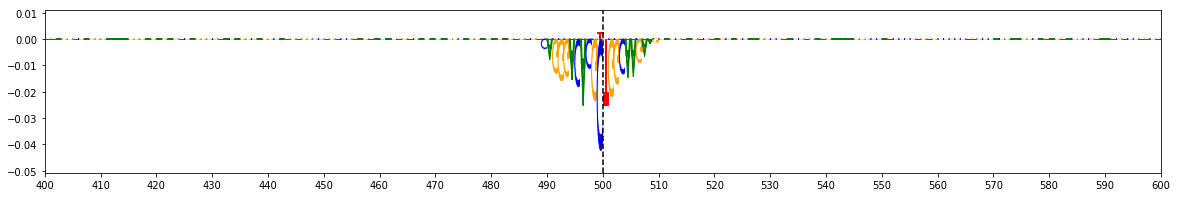


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 481   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  2.35E-03
Nalls_23andMe 		  2.35E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.3487   ||   Center / 200bp : 0.4742
Noneffect Sequence : AGCTGAGGGCGCTGTTGATG


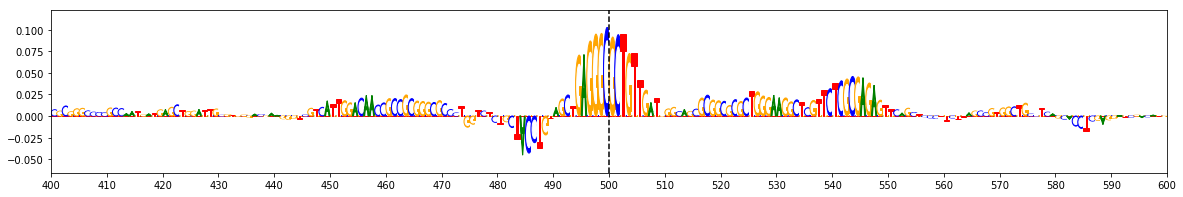

Effect Allele : T   ||   Explain Score : 0.737   ||   Center / 200bp : 0.3298
Effect Sequence : AGCTGAGGGTGCTGTTGATG


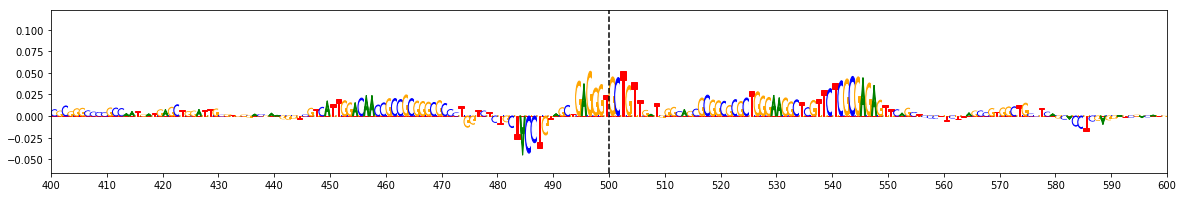

Allele Ratio : 0.5465   ||   Allele Difference : -0.6142  ||  ISM Score : -0.9676  ||  deltaSVM Score : -5.5866


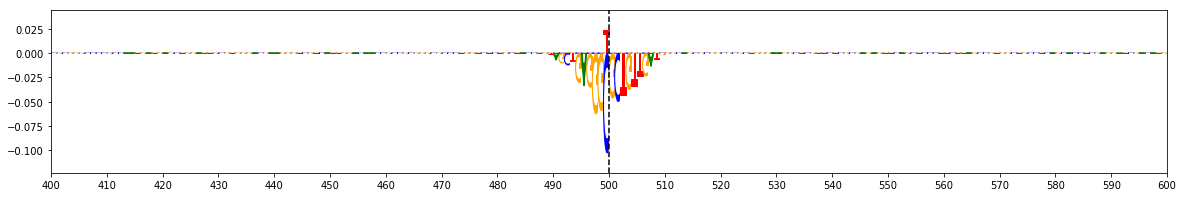


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17689824   ||    chr17 : 45827030 - 45827031   ||    Locus: 162   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.33E-22
Parkinsons_Pankratz_2012 	  1.21E-09

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.5219   ||   Center / 200bp : 0.3732
Noneffect Sequence : AAGAGGGAGCTTAAAGCCAG


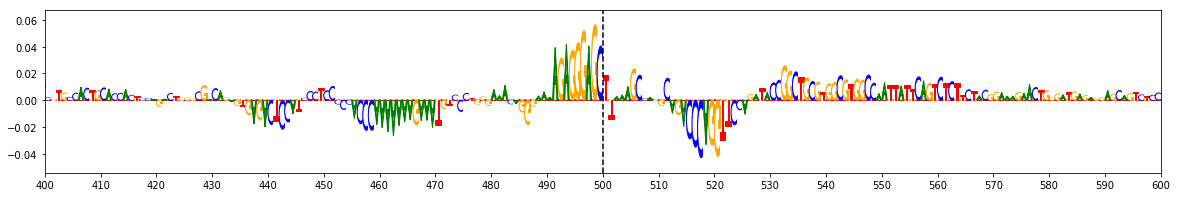

Effect Allele : T   ||   Explain Score : 0.2282   ||   Center / 200bp : 0.2065
Effect Sequence : AAGAGGGAGTTTAAAGCCAG


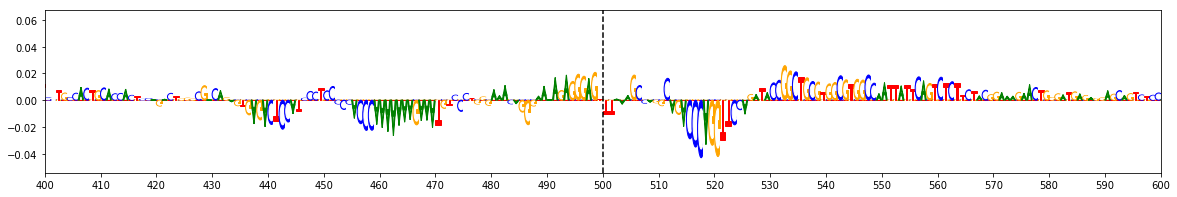

Allele Ratio : 0.4373   ||   Allele Difference : -0.3084  ||  ISM Score : -0.4808  ||  deltaSVM Score : -2.8308


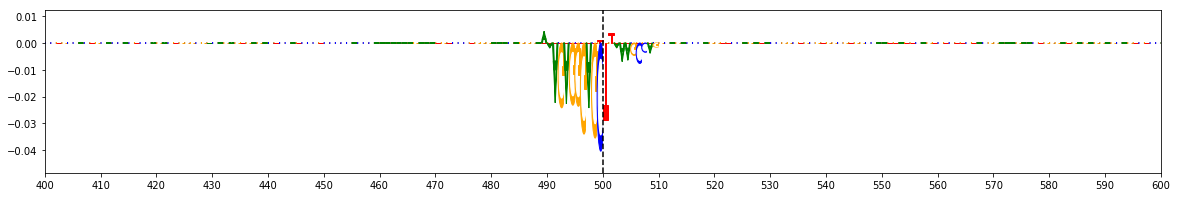


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1388597   ||    chr12 : 40224294 - 40224295   ||    Locus: 61   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.37E-03

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.886   ||   Center / 200bp : 0.5992
Noneffect Sequence : CTCACAGGGAAACAATGTTT


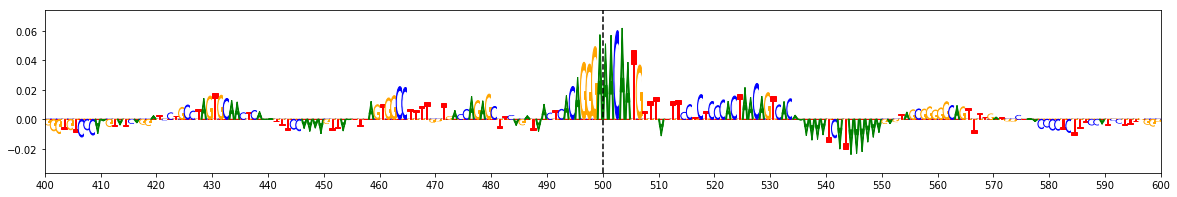

Effect Allele : G   ||   Explain Score : 0.6227   ||   Center / 200bp : 0.5118
Effect Sequence : CTCACAGGGGAACAATGTTT


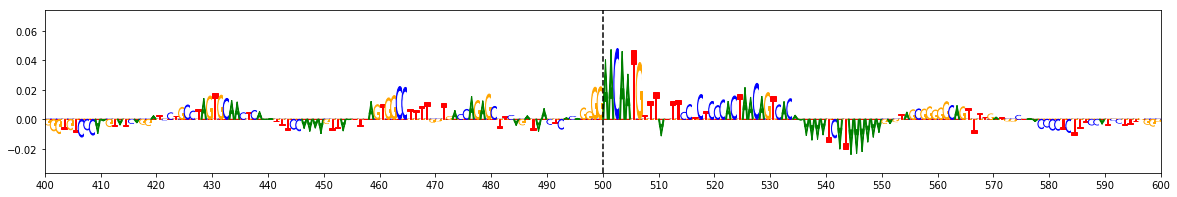

Allele Ratio : 0.7029   ||   Allele Difference : -0.2756  ||  ISM Score : -0.427  ||  deltaSVM Score : -2.4202


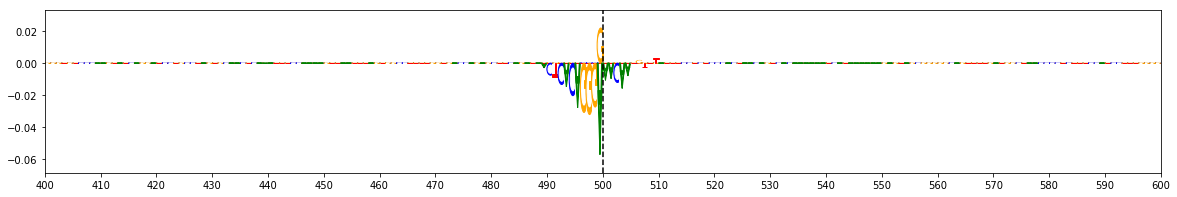


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect         ref  \
234  chr17   45934891   45934892   rs66755419      I         D          CG   
177  chr17   45852666   45852667   rs62054825      G         A           G   
150  chr17   45825577   45825578    rs1912151      T         C           C   
211  chr17   45896863   45896864   rs62056782      T         C           C   
247  chr17   45947293   45947294   rs62062786      G         C           G   
11    chr1  232508907  232508908   rs12073680      G         A           A   
309  chr17   46213482   46213483   rs76475191      T         A           T   
232  chr17   45934729   45934730   rs62061716      G         A           A   
0     chr1   39878995   39878996    rs7527412      A         G           G   
508   chr4     987143     987144   rs10902762      G         A           G   
595   chr8   22604860   22604861    rs3735901      T         C           T   
454   chr2  127128047  127128048   rs55828408      A         T           T   
465   chr2  127137181  127137182     rs893433      C         G           C   
314  chr17   46771150   46771151     rs199523      C         A           C   
310  chr17   46213483   46213484   rs78826239      T         A           T   
434   chr2  101804485  101804486   rs35523846      T         A           T   
537   chr4   89828891   89828892   rs33965306    NAN       NAN           A   
213  chr17   45897109   45897110   rs80346216      T         G           G   
572   chr6  132812798  132812799   rs79333841      G         C           C   
607   chr9   33878567   33878568   rs10119038      G         A           A   
147  chr17   45825432   45825433    rs3885075      G         A           A   
354  chr19    1040765    1040766    rs4147904      A         G           A   
263  chr17   46013337   46013338   rs62062266      G         A           A   
571   chr6   27772886   27772887    rs9468223      T         C           C   
239  chr17   45940574   45940575   rs62061732      T         G           G   
10    chr1  226737182  226737183  rs147889095      I         D  ACTGCCGCTG   
594   chr8   22599691   22599692     rs755934      T         G           T   
275  chr17   46082683   46082684   rs62060852      G         A           G   
308  chr17   46213392   46213393    rs2668662      T         C           T   
593   chr8   11845910   11845911    rs1736082      T         C           C   
..     ...        ...        ...          ...    ...       ...         ...   
347  chr17   78433290   78433291    rs6501212      G         A           G   
567   chr5  103224361  103224362     rs152137      T         C           C   
223  chr17   45923861   45923862   rs62058968      G         A           G   
326  chr17   75034714   75034715   rs11870474      A         C           C   
494   chr3   52597590   52597591  rs143667157      C         A           A   
580   chr7   23231411   23231412    rs1728313      C         A           A   
512   chr4   89709523   89709524     rs356177      C         A           C   
22   chr11   47255123   47255124   rs11039149      A         G           A   
170  chr17   45848689   45848690   rs62054818      C         A           A   
385  chr19   44925201   44925202    rs4803772      T         C           C   
105  chr16   52592638   52592639    rs3112624      G         A           A   
498   chr3  151383902  151383903   rs10935841      T         C           C   
129  chr17   44220262   44220263  rs113844752      C         A           C   
212  chr17   45896987   45896988  rs113161176      G         A           G   
31   chr11   60194012   60194013   rs11230180      T         G           G   
119  chr17    4902141    4902142   rs72835061      A         C           C   
37   chr11   65888810   65888811     rs656980      A         G           G   
64   chr12  122836031  122836032   rs12820345      T         G           G   
437   chr2  127081957  127081958   rs11690153      C         T           T   
564   chr5  103101163  103101

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs66755419   ||    chr17 : 45934891 - 45934892   ||    Locus: 234   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  4.59E-22

Coloc:  True

Effect Allele: I   ||  Explain Score: 0.5087   ||  Center / 200bp: 0.5497
Effect Sequence: TTCCCCCCCCTTCTTAGAAG


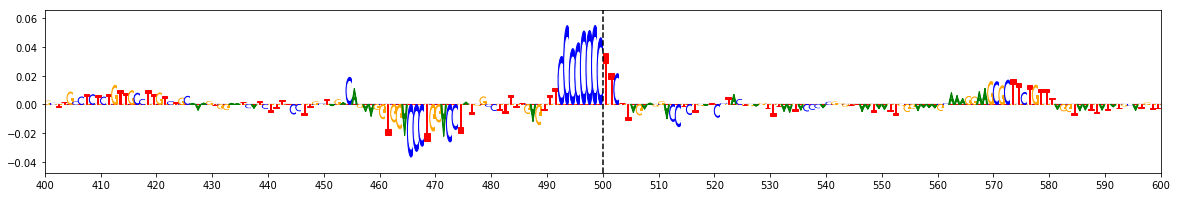

Noneffect Allele: D   ||  Explain Score: 0.0952   ||  Center / 200bp: 0.1853
Noneffect Sequence: TTCCCCCCCGCTTCTTAGAA


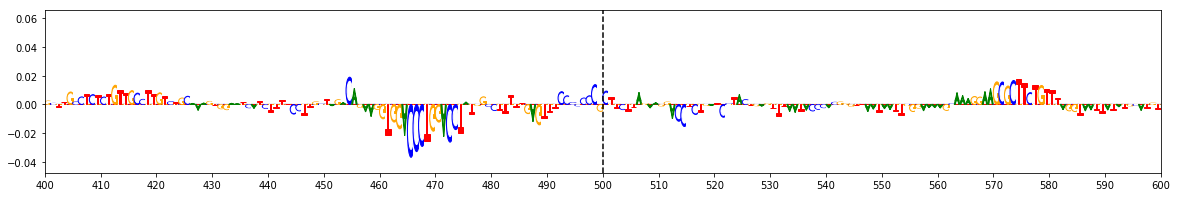

Allele Ratio : 5.3423   ||   Allele Difference : 0.4204  ||  ISM Score : 0.6551  ||  deltaSVM Score : 3.9315


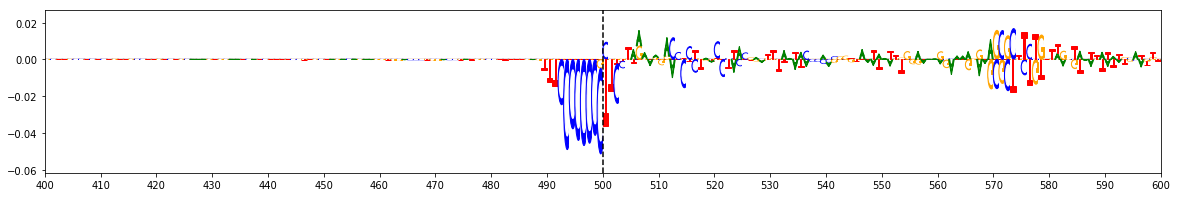


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62054825   ||    chr17 : 45852666 - 45852667   ||    Locus: 177   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.25E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.9445   ||  Center / 200bp: 0.7747
Effect Sequence: TGAGCTCCCGGAAGTGGAGT


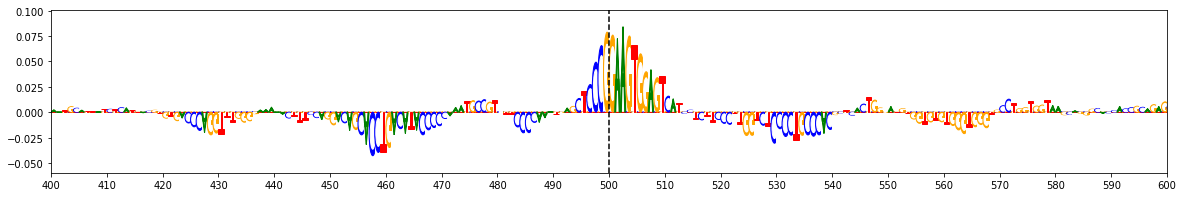

Noneffect Allele: A   ||  Explain Score: 0.2612   ||  Center / 200bp: 0.4872
Noneffect Sequence: TGAGCTCCCAGAAGTGGAGT


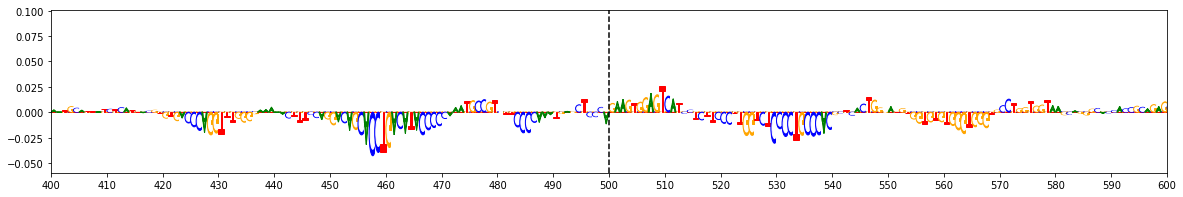

Allele Ratio : 3.6164   ||   Allele Difference : 0.7119  ||  ISM Score : 1.1146  ||  deltaSVM Score : 6.3675


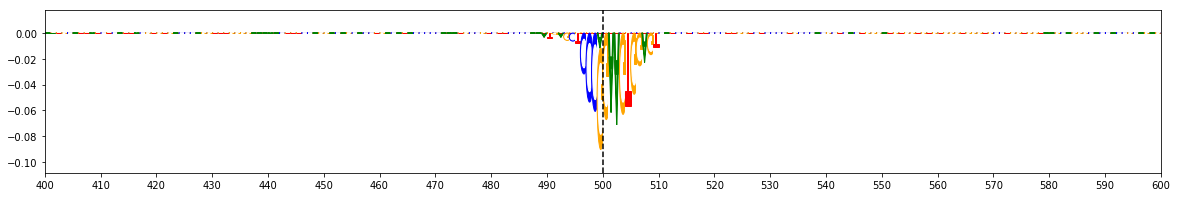


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1912151   ||    chr17 : 45825577 - 45825578   ||    Locus: 150   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.33E-22
Parkinsons_Pankratz_2012 	  1.22E-09

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.4129   ||  Center / 200bp: 0.3668
Effect Sequence: GGTTCACTGTTCACCGTGTG


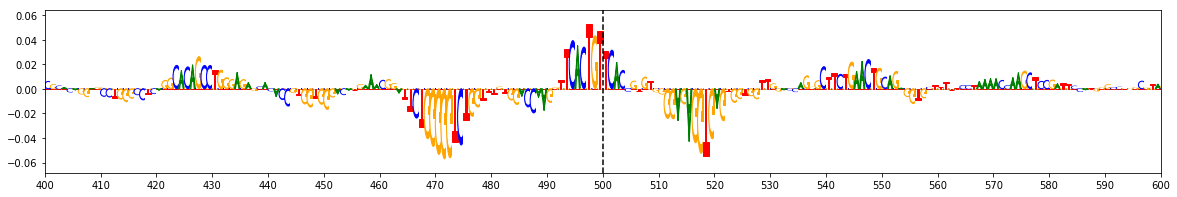

Noneffect Allele: C   ||  Explain Score: 0.0648   ||  Center / 200bp: 0.0835
Noneffect Sequence: GGTTCACTGCTCACCGTGTG


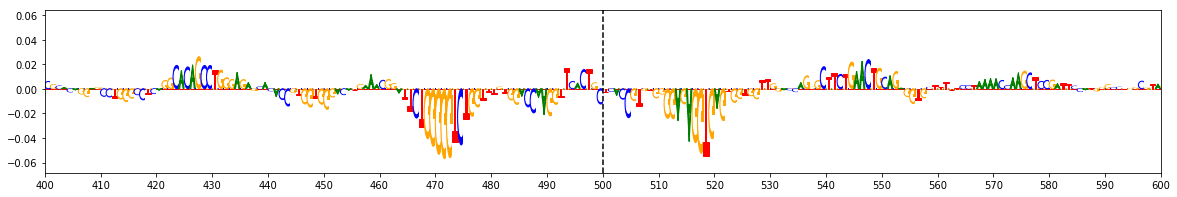

Allele Ratio : 6.3672   ||   Allele Difference : 0.4635  ||  ISM Score : 0.729  ||  deltaSVM Score : 4.2243


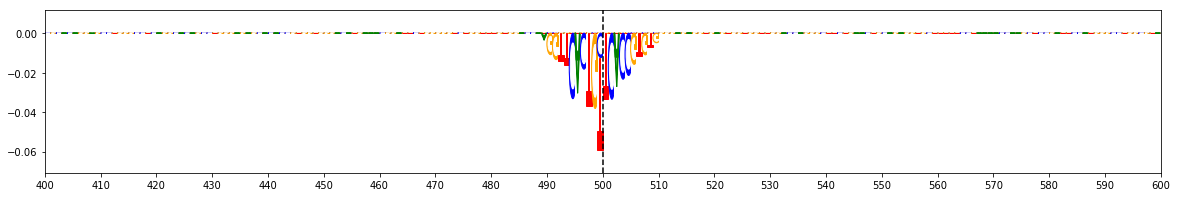


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62056782   ||    chr17 : 45896863 - 45896864   ||    Locus: 211   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.8049   ||  Center / 200bp: 0.7387
Effect Sequence: CTCGCCCTCTTGTGATGAAC


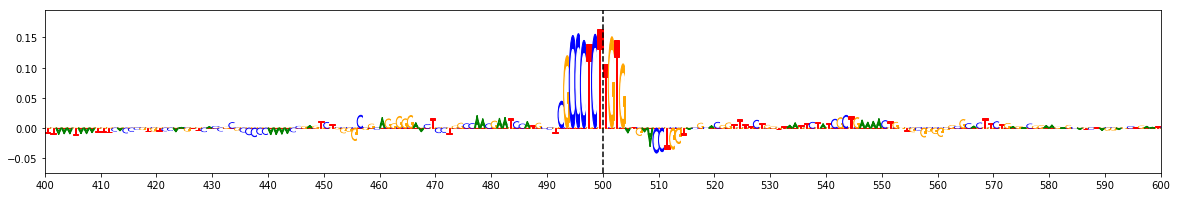

Noneffect Allele: C   ||  Explain Score: 0.6094   ||  Center / 200bp: 0.4884
Noneffect Sequence: CTCGCCCTCCTGTGATGAAC


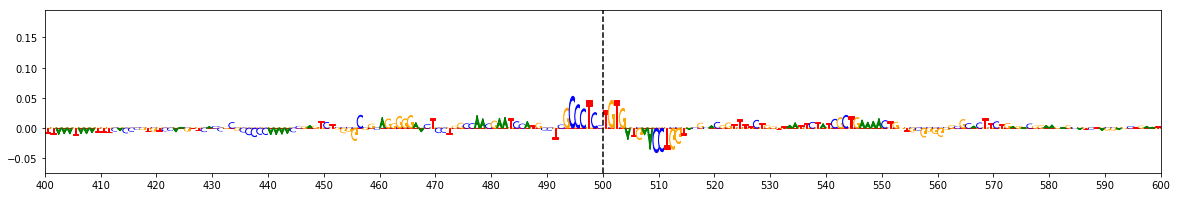

Allele Ratio : 2.9619   ||   Allele Difference : 1.2497  ||  ISM Score : 1.9518  ||  deltaSVM Score : 11.2081


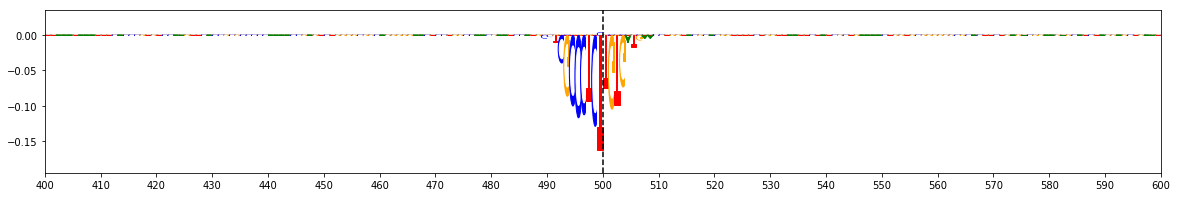


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062786   ||    chr17 : 45947293 - 45947294   ||    Locus: 247   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  4.53E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.6668   ||  Center / 200bp: 0.5079
Effect Sequence: TGGGGACCAGCTGCCACAGA


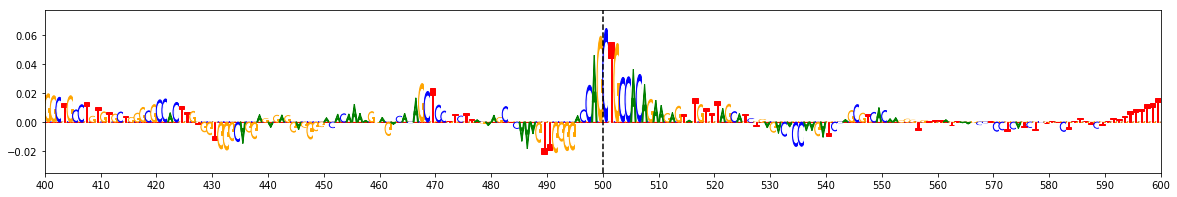

Noneffect Allele: C   ||  Explain Score: 0.1765   ||  Center / 200bp: 0.2146
Noneffect Sequence: TGGGGACCACCTGCCACAGA


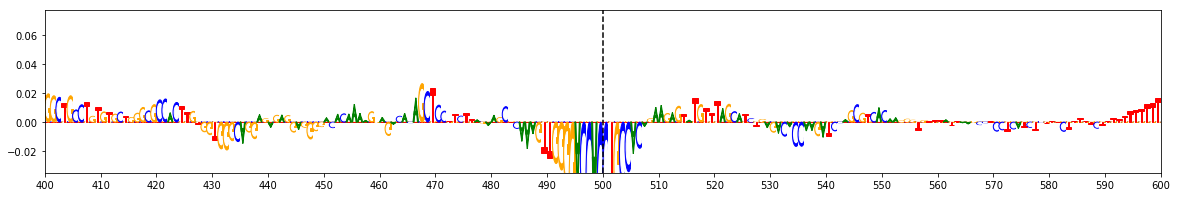

Allele Ratio : 3.7783   ||   Allele Difference : 1.2953  ||  ISM Score : 2.111  ||  deltaSVM Score : 12.0692


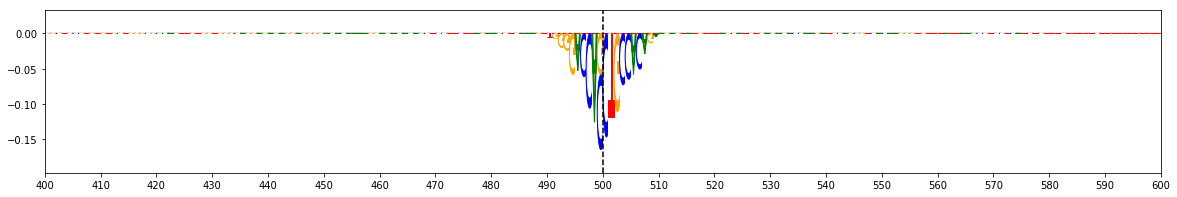


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12073680   ||    chr1 : 232508907 - 232508908   ||    Locus: 11   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  3.90E-03
Nalls_23andMe 		  3.90E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.146   ||  Center / 200bp: 0.4524
Effect Sequence: CTGGCCAACGCGGCGAAACC


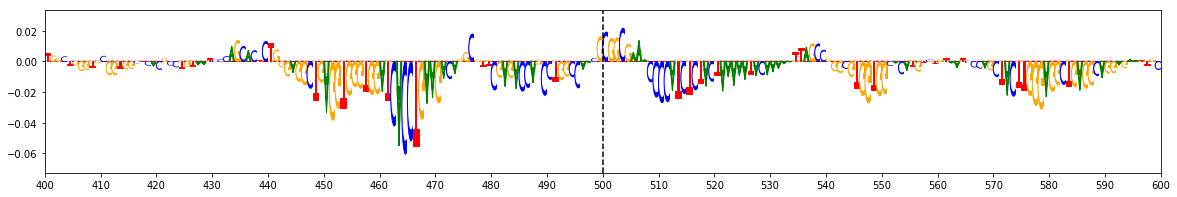

Noneffect Allele: A   ||  Explain Score: 0.0509   ||  Center / 200bp: 0.2238
Noneffect Sequence: CTGGCCAACACGGCGAAACC


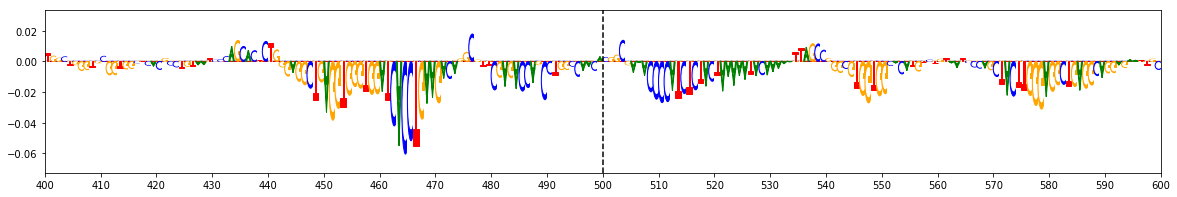

Allele Ratio : 2.8683   ||   Allele Difference : 0.1025  ||  ISM Score : 0.1638  ||  deltaSVM Score : 0.9296


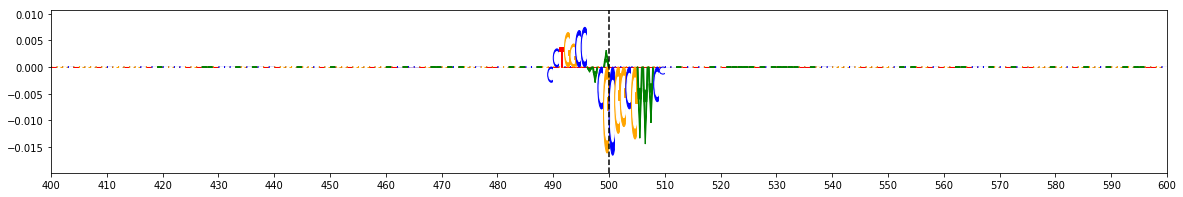


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs76475191   ||    chr17 : 46213482 - 46213483   ||    Locus: 309   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.10E-18

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.4129   ||  Center / 200bp: 0.5815
Effect Sequence: TTTTTTTTTTTTTTTTAGTA


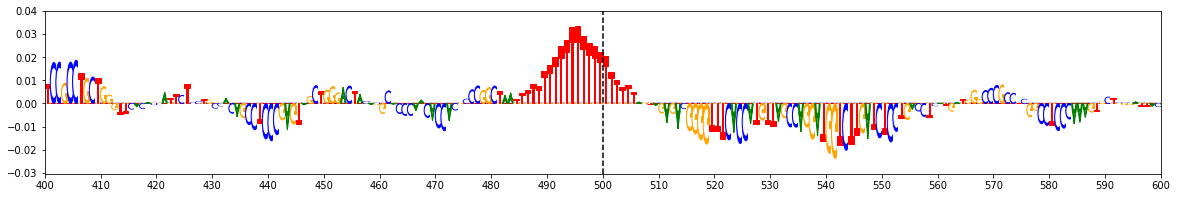

Noneffect Allele: A   ||  Explain Score: 0.1963   ||  Center / 200bp: 0.3322
Noneffect Sequence: TTTTTTTTTATTTTTTAGTA


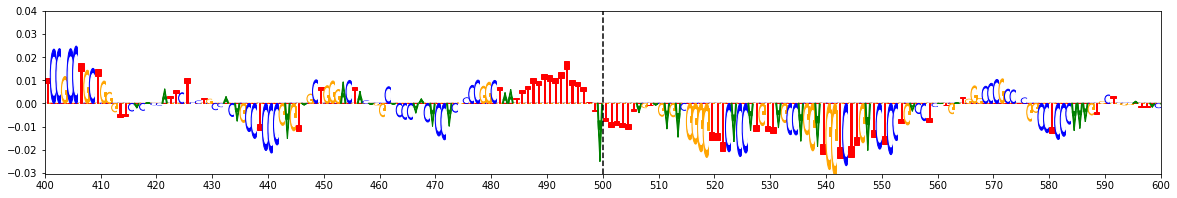

Allele Ratio : 2.1034   ||   Allele Difference : 0.3598  ||  ISM Score : 0.4083  ||  deltaSVM Score : 12.1916


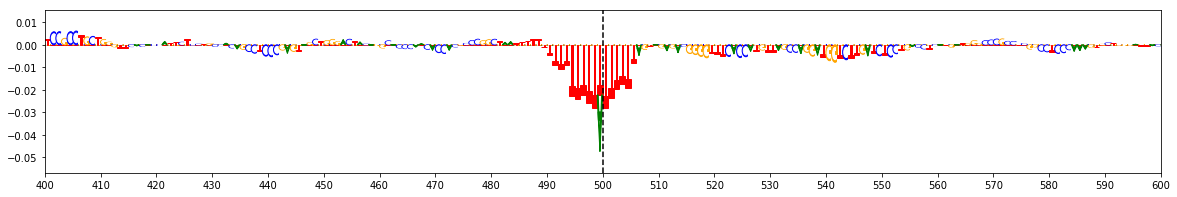


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62061716   ||    chr17 : 45934729 - 45934730   ||    Locus: 232   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  4.04E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 1.6094   ||  Center / 200bp: 0.7049
Effect Sequence: TCTGCTCTAGGAGGCAGTAG


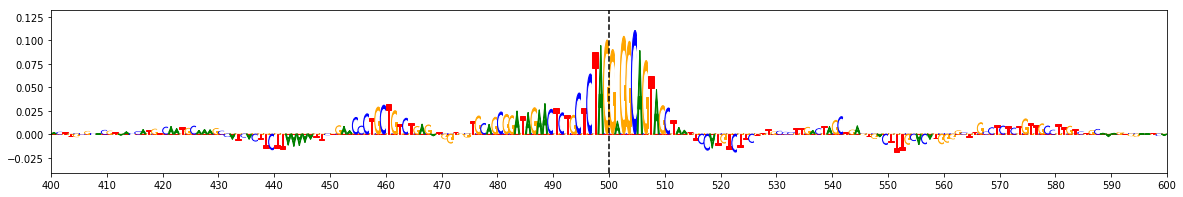

Noneffect Allele: A   ||  Explain Score: 0.9676   ||  Center / 200bp: 0.5897
Noneffect Sequence: TCTGCTCTAAGAGGCAGTAG


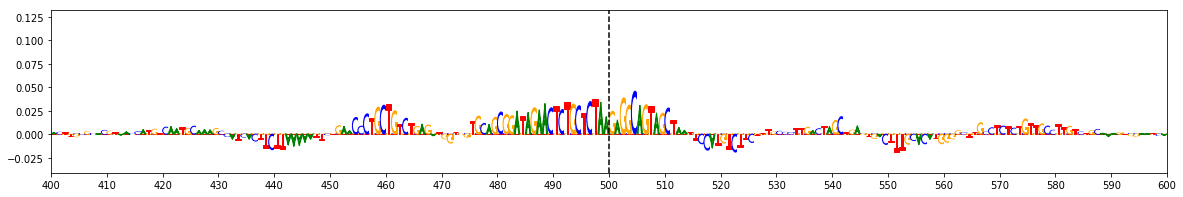

Allele Ratio : 1.6632   ||   Allele Difference : 0.6416  ||  ISM Score : 0.9995  ||  deltaSVM Score : 5.6904


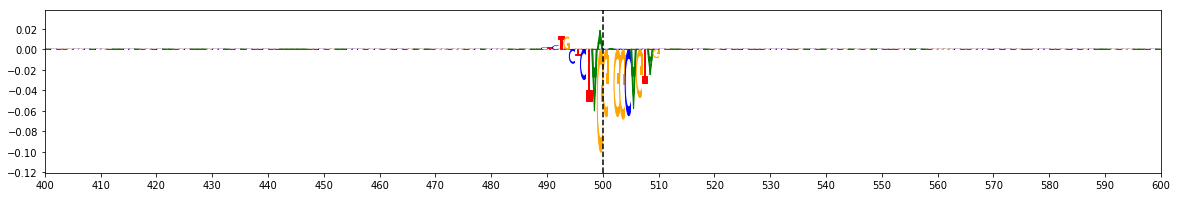


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7527412   ||    chr1 : 39878995 - 39878996   ||    Locus: 0   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  1.35E-05

Coloc:  True

Effect Allele: A   ||  Explain Score: 0.7675   ||  Center / 200bp: 0.6974
Effect Sequence: TGGCCTGGCACAGTGGCTCA


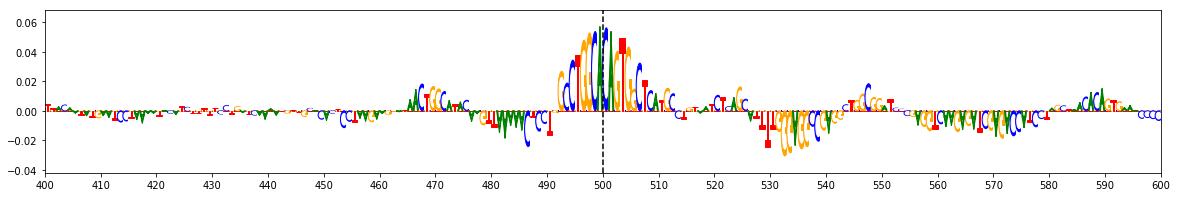

Noneffect Allele: G   ||  Explain Score: 0.4617   ||  Center / 200bp: 0.5809
Noneffect Sequence: TGGCCTGGCGCAGTGGCTCA


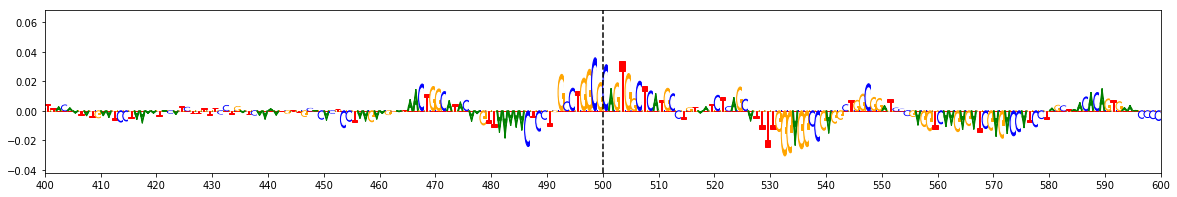

Allele Ratio : 1.6623   ||   Allele Difference : 0.2963  ||  ISM Score : 0.4627  ||  deltaSVM Score : 2.6414


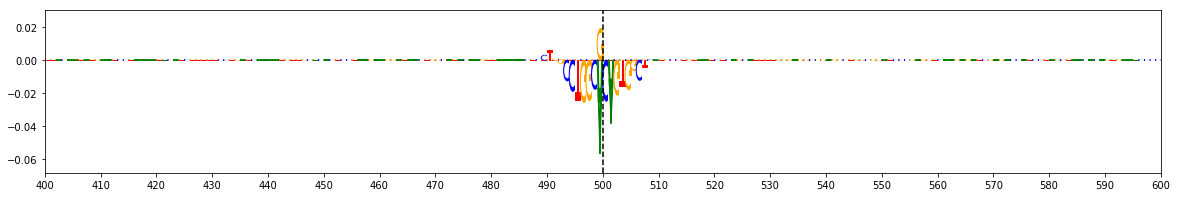


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10902762   ||    chr4 : 987143 - 987144   ||    Locus: 508   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.90E-11

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.3689   ||  Center / 200bp: 0.4011
Effect Sequence: CCTGGCCGCGCCCCCGGTGG


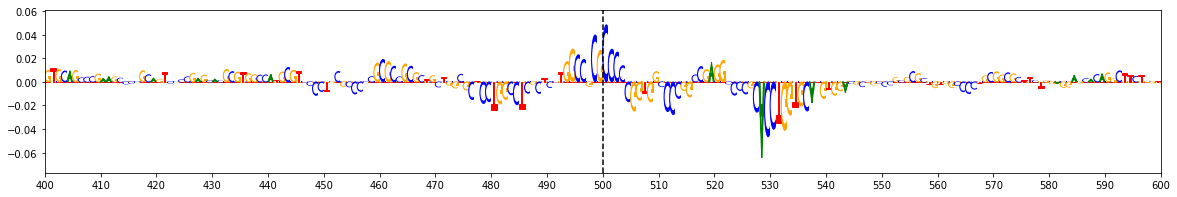

Noneffect Allele: A   ||  Explain Score: 0.1282   ||  Center / 200bp: 0.1864
Noneffect Sequence: CCTGGCCGCACCCCCGGTGG


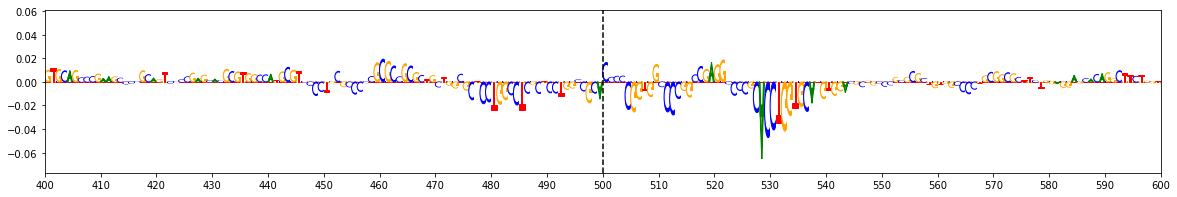

Allele Ratio : 2.8775   ||   Allele Difference : 0.3287  ||  ISM Score : 0.536  ||  deltaSVM Score : 3.1824


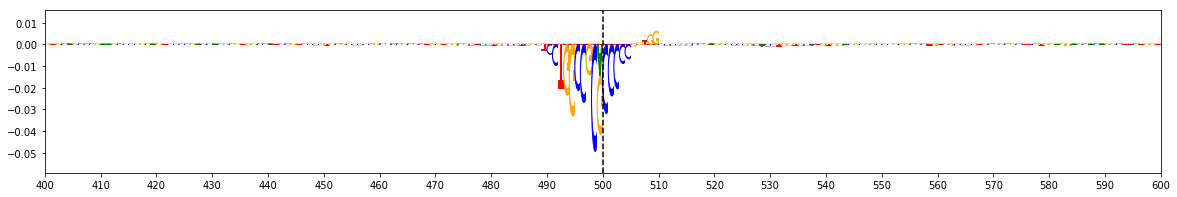


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3735901   ||    chr8 : 22604860 - 22604861   ||    Locus: 595   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  5.08E-02
Nalls_23andMe 		  5.08E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.32   ||  Center / 200bp: 0.183
Effect Sequence: GGGGCCCCCTGCCGCCCCTC


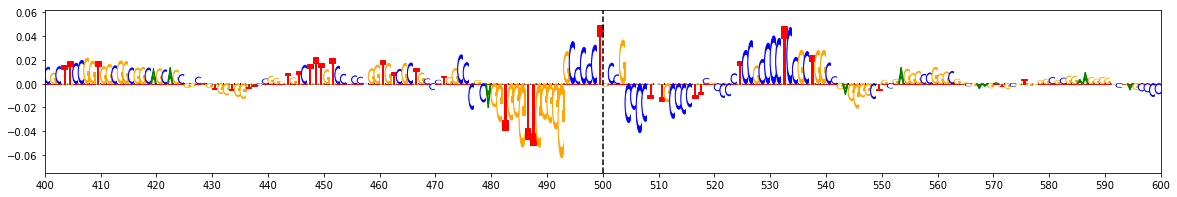

Noneffect Allele: C   ||  Explain Score: 0.0521   ||  Center / 200bp: 0.0362
Noneffect Sequence: GGGGCCCCCCGCCGCCCCTC


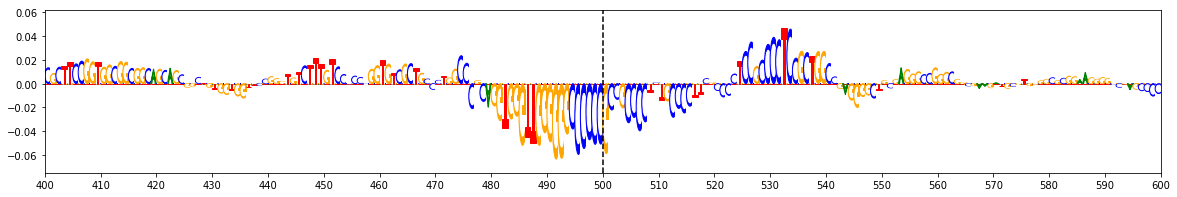

Allele Ratio : 6.1399   ||   Allele Difference : 0.7594  ||  ISM Score : 1.1982  ||  deltaSVM Score : 7.846


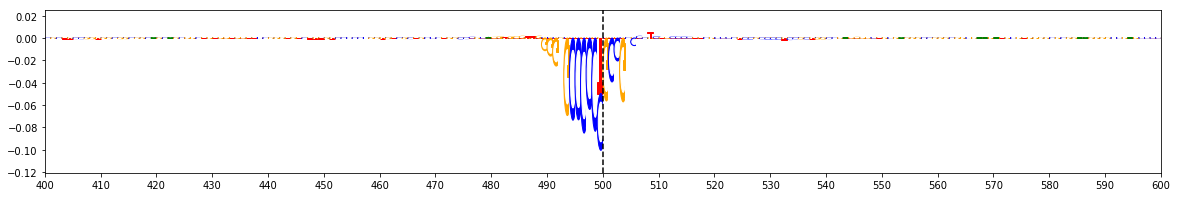


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs55828408   ||    chr2 : 127128047 - 127128048   ||    Locus: 454   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.67E-14

Coloc:  False

Effect Allele: A   ||  Explain Score: 0.5888   ||  Center / 200bp: 0.7115
Effect Sequence: TGTTGAATTATGCCGAATGC


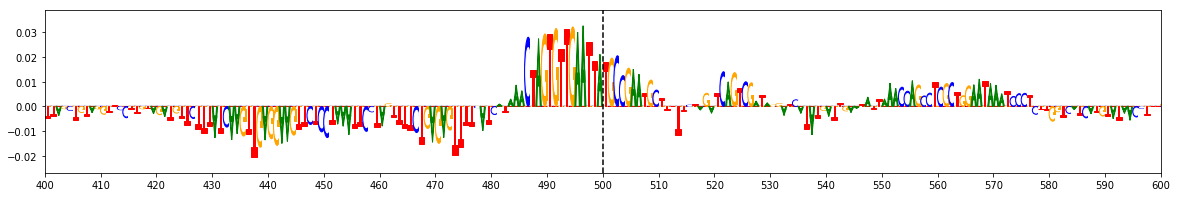

Noneffect Allele: T   ||  Explain Score: 0.3859   ||  Center / 200bp: 0.618
Noneffect Sequence: TGTTGAATTTTGCCGAATGC


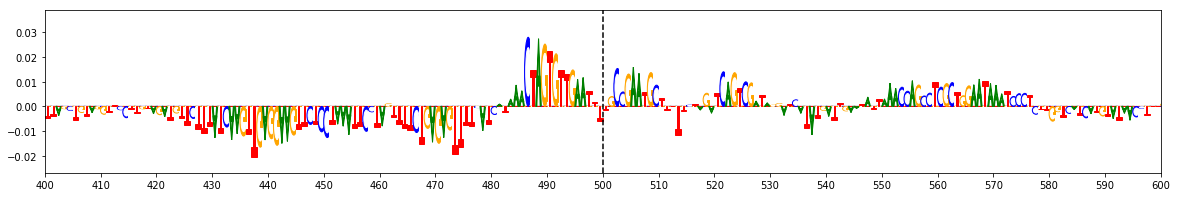

Allele Ratio : 1.5259   ||   Allele Difference : 0.2099  ||  ISM Score : 0.3276  ||  deltaSVM Score : 1.9045


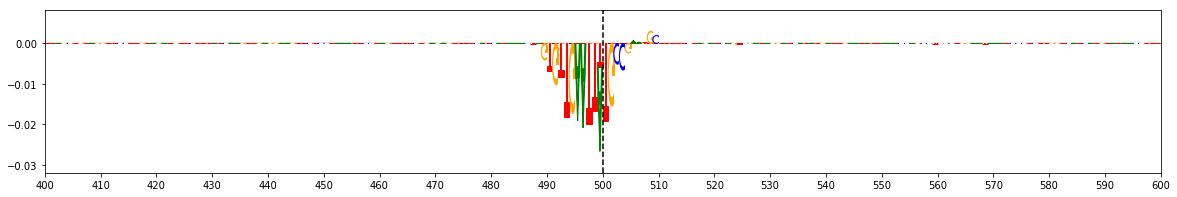


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs893433   ||    chr2 : 127137181 - 127137182   ||    Locus: 465   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  8.18E-02

Coloc:  False

Effect Allele: C   ||  Explain Score: 1.2355   ||  Center / 200bp: 0.6169
Effect Sequence: ACTGGGCTGCAGCTGCTTTT


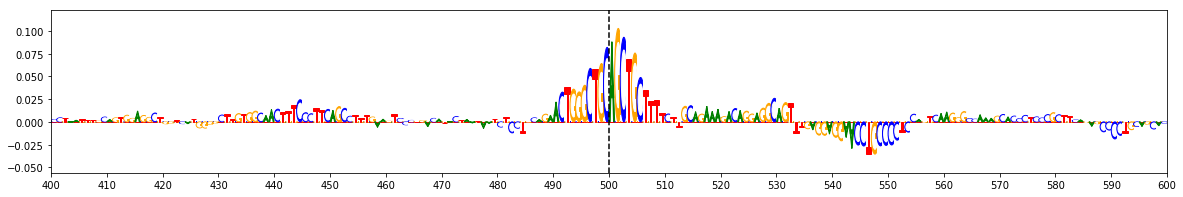

Noneffect Allele: G   ||  Explain Score: 0.7113   ||  Center / 200bp: 0.4808
Noneffect Sequence: ACTGGGCTGGAGCTGCTTTT


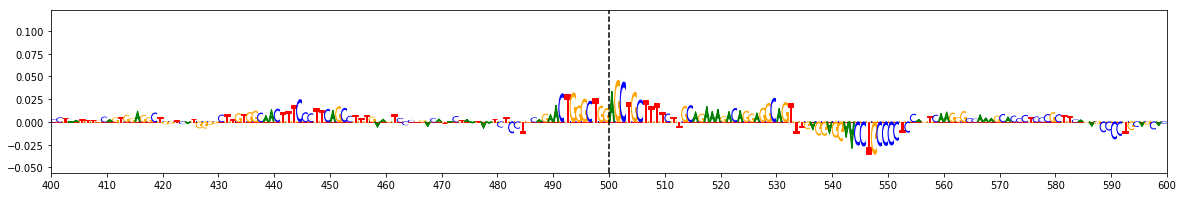

Allele Ratio : 1.7369   ||   Allele Difference : 0.5242  ||  ISM Score : 0.814  ||  deltaSVM Score : 4.6673


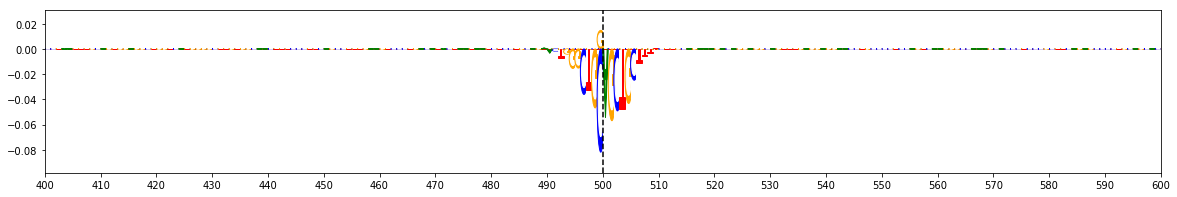


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs199523   ||    chr17 : 46771150 - 46771151   ||    Locus: 314   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  9.49E-14

Coloc:  True

Effect Allele: C   ||  Explain Score: 1.3082   ||  Center / 200bp: 0.4827
Effect Sequence: GCCCTCCTGCGCCACCTACA


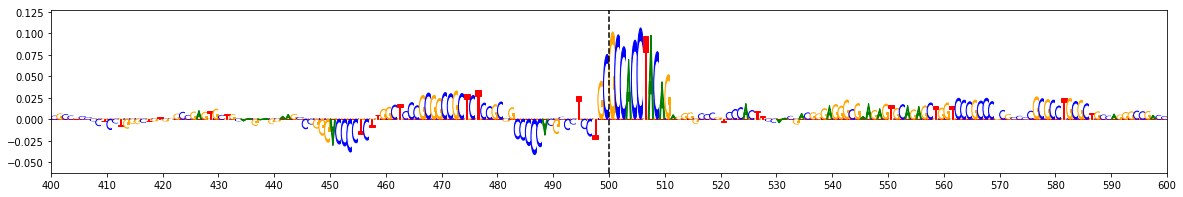

Noneffect Allele: A   ||  Explain Score: 0.5908   ||  Center / 200bp: 0.2961
Noneffect Sequence: GCCCTCCTGAGCCACCTACA


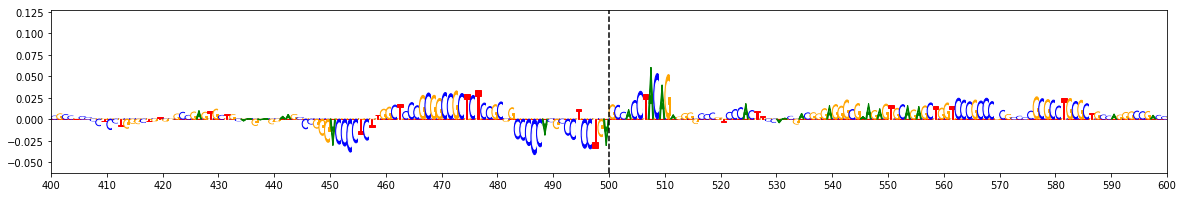

Allele Ratio : 2.2141   ||   Allele Difference : 0.8367  ||  ISM Score : 1.3284  ||  deltaSVM Score : 7.6621


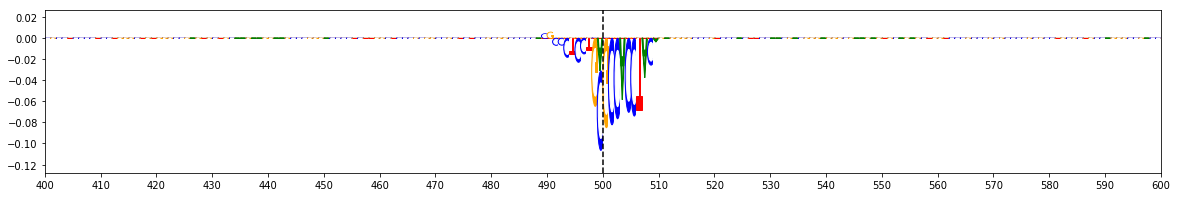


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs78826239   ||    chr17 : 46213483 - 46213484   ||    Locus: 310   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.10E-18

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.4096   ||  Center / 200bp: 0.583
Effect Sequence: TTTTTTTTTTTTTTTAGTAG


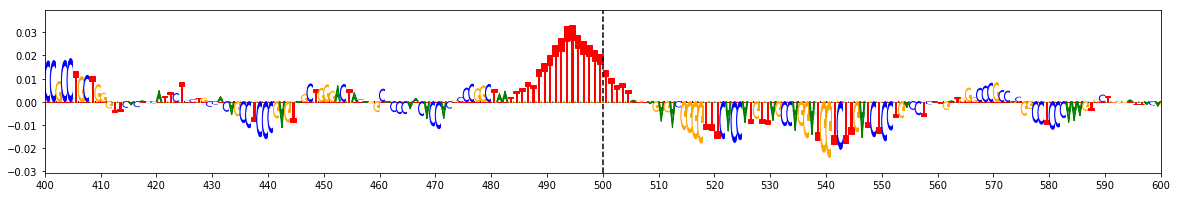

Noneffect Allele: A   ||  Explain Score: 0.2289   ||  Center / 200bp: 0.3795
Noneffect Sequence: TTTTTTTTTATTTTTAGTAG


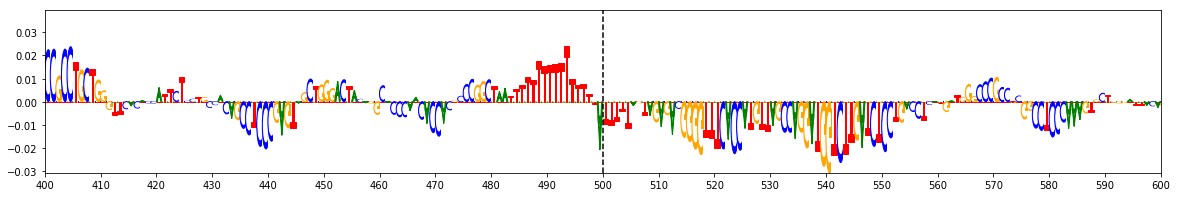

Allele Ratio : 1.7893   ||   Allele Difference : 0.316  ||  ISM Score : 0.3603  ||  deltaSVM Score : 10.6141


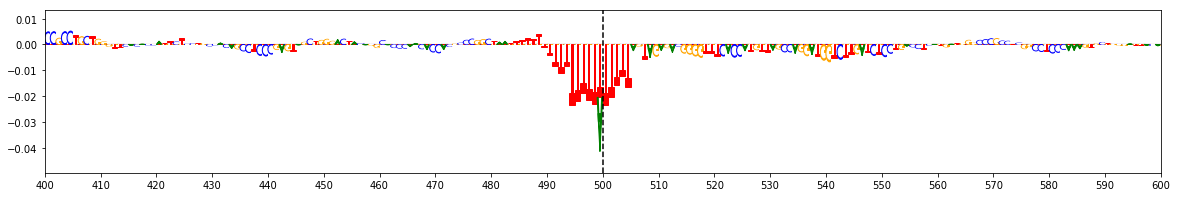


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs35523846   ||    chr2 : 101804485 - 101804486   ||    Locus: 434   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.46E-03
Chang_23andMe_Parkinsons 	  1.46E-03

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.0638   ||  Center / 200bp: 0.6997
Effect Sequence: CCACTGTCTTTGTCAGTTAT


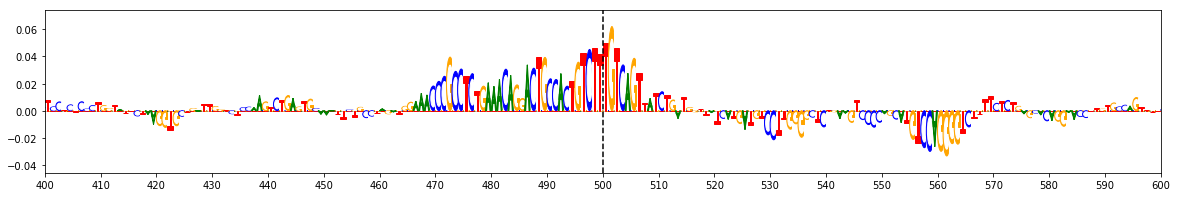

Noneffect Allele: A   ||  Explain Score: 0.8291   ||  Center / 200bp: 0.6449
Noneffect Sequence: CCACTGTCTATGTCAGTTAT


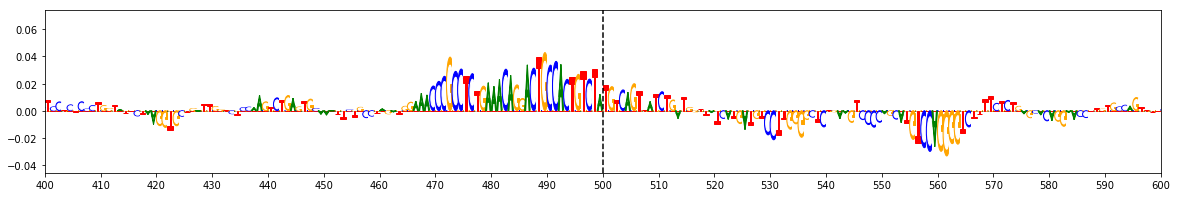

Allele Ratio : 1.283   ||   Allele Difference : 0.2347  ||  ISM Score : 0.365  ||  deltaSVM Score : 2.0338


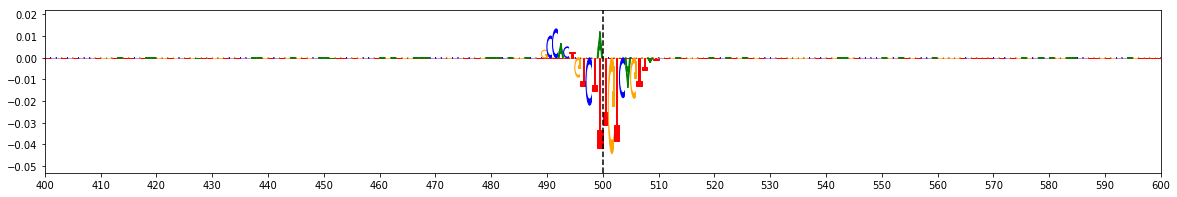


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs33965306   ||    chr4 : 89828891 - 89828892   ||    Locus: 537   ||    IDR Peak: False

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.07E-08

Coloc:  True

Effect Allele: NAN   ||  Explain Score: 0.8133   ||  Center / 200bp: 0.6876
Effect Sequence: CAGTGAGCCGAGATTGTGCC


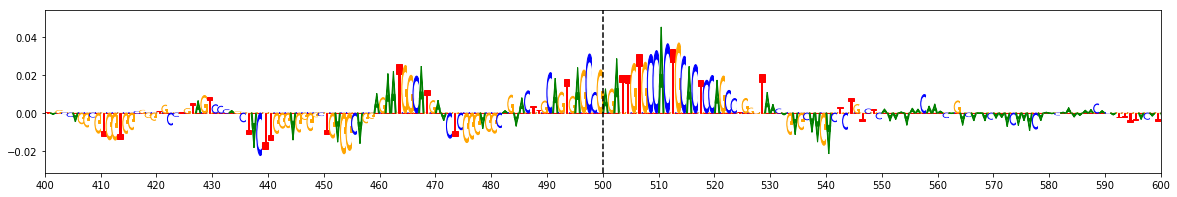

Noneffect Allele: NAN   ||  Explain Score: 0.6275   ||  Center / 200bp: 0.6295
Noneffect Sequence: CAGTGAGCCAAGATTGTGCC


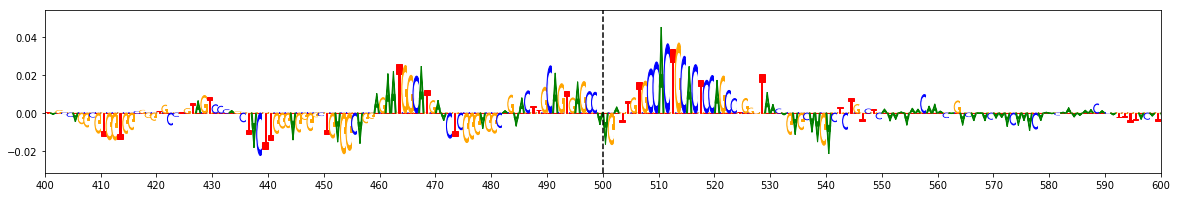

Allele Ratio : 1.2961   ||   Allele Difference : 0.2294  ||  ISM Score : 0.3757  ||  deltaSVM Score : 2.1339


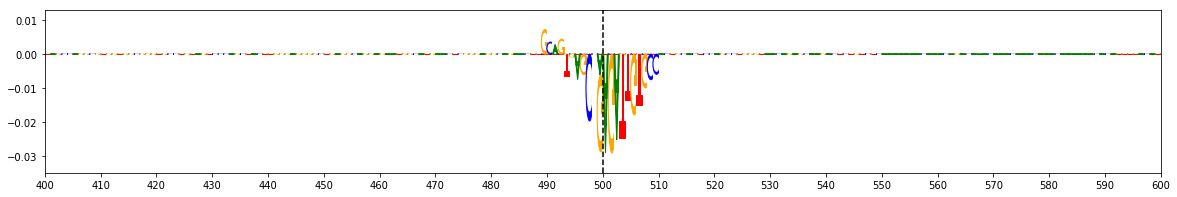


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs80346216   ||    chr17 : 45897109 - 45897110   ||    Locus: 213   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.7798   ||  Center / 200bp: 0.5631
Effect Sequence: GCCCGCCGCTAGGGGTTGCA


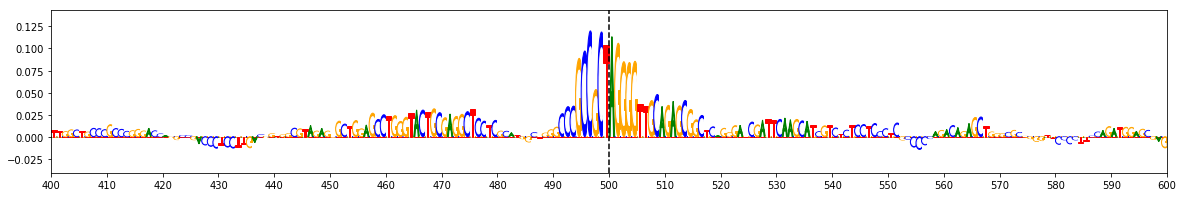

Noneffect Allele: G   ||  Explain Score: 1.1277   ||  Center / 200bp: 0.4498
Noneffect Sequence: GCCCGCCGCGAGGGGTTGCA


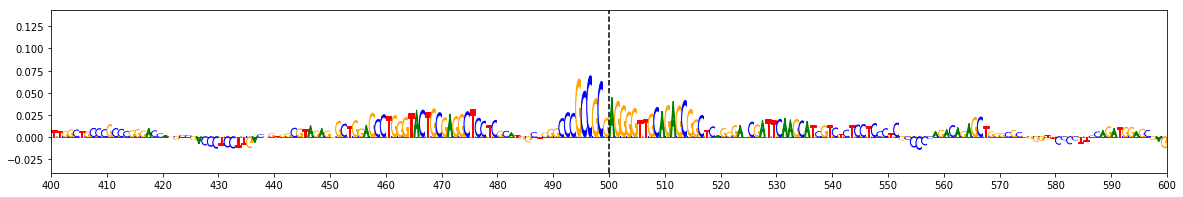

Allele Ratio : 1.5783   ||   Allele Difference : 0.6521  ||  ISM Score : 1.0182  ||  deltaSVM Score : 5.815


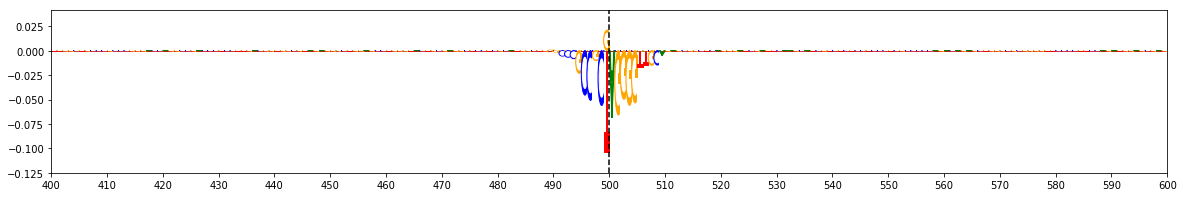


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79333841   ||    chr6 : 132812798 - 132812799   ||    Locus: 572   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  7.66E-04

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.4788   ||  Center / 200bp: 0.4295
Effect Sequence: CCTTTGCCCGTACACTTTCA


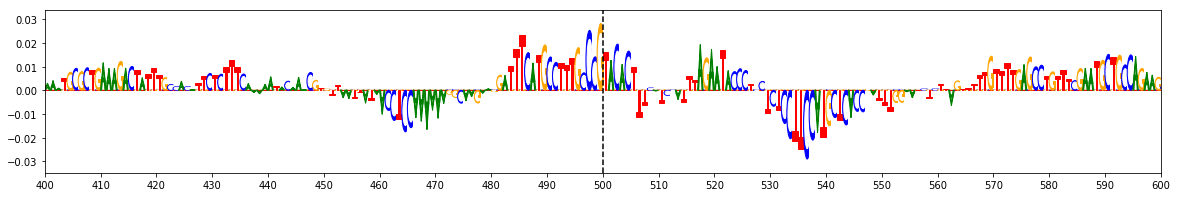

Noneffect Allele: C   ||  Explain Score: 0.2359   ||  Center / 200bp: 0.2706
Noneffect Sequence: CCTTTGCCCCTACACTTTCA


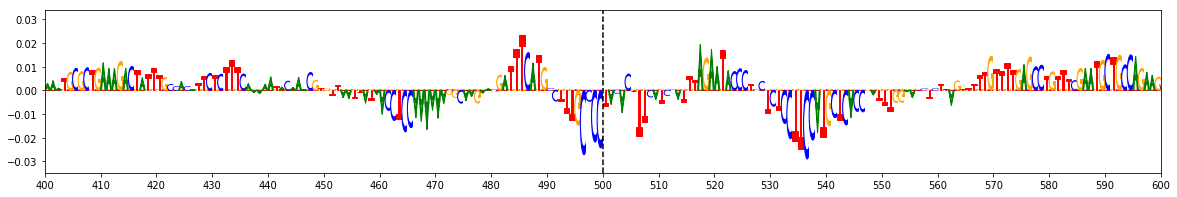

Allele Ratio : 2.0293   ||   Allele Difference : 0.4125  ||  ISM Score : 0.6446  ||  deltaSVM Score : 3.7565


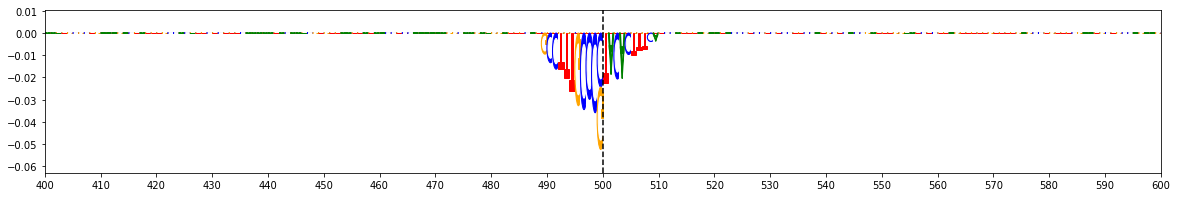


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10119038   ||    chr9 : 33878567 - 33878568   ||    Locus: 607   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.89E-01

Coloc:  False

Effect Allele: G   ||  Explain Score: 1.0364   ||  Center / 200bp: 0.6229
Effect Sequence: TATGAGCCAGGATTGCACCA


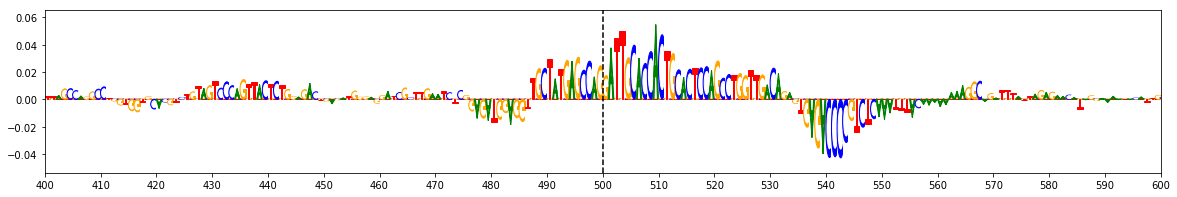

Noneffect Allele: A   ||  Explain Score: 0.7793   ||  Center / 200bp: 0.5535
Noneffect Sequence: TATGAGCCAAGATTGCACCA


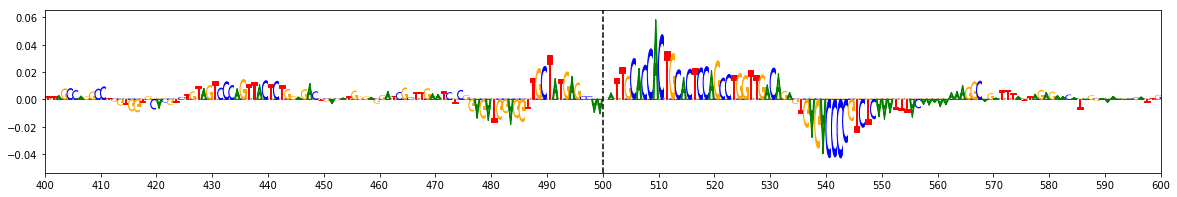

Allele Ratio : 1.3299   ||   Allele Difference : 0.278  ||  ISM Score : 0.435  ||  deltaSVM Score : 2.4665


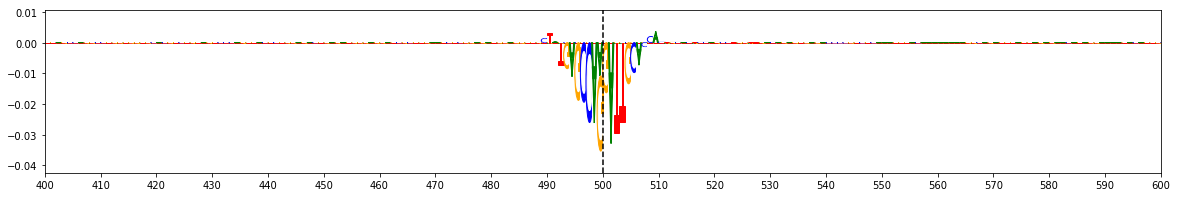


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()